# Gene mutation analysis

In [1]:
import matplotlib
from matplotlib import pyplot
from statistics import median, mean

# Make the plots used here look kinda like ggplots
pyplot.style.use("ggplot")

# Use a consistent color scheme for relating codon positions to colors
# Uses a hopefully colorblind-friendly grayscale scheme, where CP 1 = black, CP 2 = gray, and CP 3 = white
# (This should be accompanied by black borders around each color so that the gray/white are easily visible on
# a light background)
cp2color = {1: "#000000", 2: "#888888", 3: "#ffffff"}
BORDERCOLOR = "#000000"

# This is the blue color used in the ggplot-style matplotlib color settings: from
# https://gist.github.com/huyng/816622
SCATTERPLOT_PT_COLOR = "#348ABD"

# Maps seq names to easier-to-remember names used in the report.
seq2name = {"edge_6104": "CAMP", "edge_1371": "BUT", "edge_2358": "BACT"}

In [2]:
def use_thousands_sep(mpl_axis):
    # Use thousands separators for positions.
    # For an arbitrary pyplot figure, you can call this function with pyplot.gca().xaxis or pyplot.gca().yaxis. 
    # Modified from https://stackoverflow.com/a/25973637 -- this is modified to work better with integers
    # (matplotlib seems to store all values as floats internally, even essentially integral things -- so we can
    # use the float.is_integer() method to see if a value is "close enough" to an integer, and if so remove the
    # trailing ".0" that happens when you try to format a float of an integer -- see
    # https://stackoverflow.com/a/21583817.)
    mpl_axis.set_major_formatter(matplotlib.ticker.FuncFormatter(
        lambda x, pos: "{:,}".format(int(x)) if x.is_integer() else "{:,}".format(x)
    ))

## Load JSON pileup data

Rather than download all of the 32 GB of pileup data from Bloom, I converted it to two (technically three) JSON files:

- `seq2pos2cov.json`: Maps sequence name to a mapping from position (1-indexed) to the number of aligned reads covering that position. This shouldn't include indels.

- `seq2pos2matches.json`: Maps sequence name to a mapping from position (1-indexed) to the number of aligned reads covering that position __that actually match the reference at this position__ (i.e. the number of `,` or `.` characters in the read bases pileup column, ignoring read quality stuff). Again, this shouldn't include indels.

- `seq2nonmatches.json`: Maps sequence name to a mapping from position (1-indexed) to another mapping, where the keys can be any of `A`, `C`, `G`, `T` and the values are the number of time this non-matching base was seen in the reads aligned to this sequence.

These JSON files are in total only 267 MB, which is a lot easier to download / work with than 32 GB of data!

**NOTE: positions are stored as strings due to this being roundtripped through JSON. TODO, if we store / load as ints this should fix pyplot stuff with plotting spectra and decrease filesize.**

In [3]:
import json
import os

JSONPREFIX = "/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/20201216_edges/"

seq2pos2cov = {}
with open(os.path.join(JSONPREFIX, "seq2pos2cov.json"), "r") as jf:
    seq2pos2cov = json.load(jf)

seq2pos2matches = {}
with open(os.path.join(JSONPREFIX, "seq2pos2matches.json"), "r") as jf:
    seq2pos2matches = json.load(jf)
    
seq2pos2nonmatches = {}
with open(os.path.join(JSONPREFIX, "seq2pos2nonmatches.json"), "r") as jf:
    seq2pos2nonmatches = json.load(jf)

In [4]:
SEQS = ["edge_6104", "edge_1371", "edge_2358"]

### Real quick: what are the average coverages of each sequence?

In [5]:
for seq in SEQS:
    covs = seq2pos2cov[seq].values()
    mean_cov = mean(covs)
    median_cov = median(covs)
    print("Sequence {} has average coverage {} and median coverage {}.".format(seq, mean_cov, median_cov))

Sequence edge_6104 has average coverage 4047.0424310681296 and median coverage 4026.0.
Sequence edge_1371 has average coverage 2162.5206404020128 and median coverage 2667.
Sequence edge_2358 has average coverage 2946.406226157373 and median coverage 2875.


### Utility functions

In [6]:
import pandas as pd
from statistics import mean

def histogram_of_123(one, two, three, title, xlabel="Codon Position", ylabel="Frequency"):
    pyplot.bar(
        x=[1, 2, 3],
        height=[one, two, three],
        color=[cp2color[1], cp2color[2], cp2color[3]],
        edgecolor=BORDERCOLOR,
        tick_label=["1", "2", "3"]
    )
    pyplot.title(title)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    # (Can disable this if needed)
    use_thousands_sep(pyplot.gca().yaxis)
    pyplot.show()
    
def get_pos_interval_from_gene(gene):
    try:
        start = int(gene.LeftEnd)
    except ValueError:
        # Account for the "<2" left end coordinate in one of the genes predicted
        start = int(gene.LeftEnd[1:])
        
    try:
        end = int(gene.RightEnd)
    except ValueError:
        # Account for the ">N" right end coordinate in one of the genes predicted
        end = int(gene.RightEnd[1:])

    if gene.Strand == "-":
        return range(end, start - 1, -1)
    elif gene.Strand == "+":
        return range(start, end + 1)
    else:
        raise ValueError("Unknown strand: {}".format(gene.Strand))
        
def histogram_maker(
    pseudo_variant_caller, title, val_aggregator=sum, min_gene_length=0, ylabel="Frequency", normalize=True,
    output_dict=False
):
    """
    Produces histograms of pileup data for the 1st, 2nd, and 3rd positions of predicted genes.

    Parameters
    ----------
    pseudo_variant_caller: function
        Takes as input two parameters:
            1. cov: an integer describing number of reads aligned to a position
            2. matches: an integer describing the number of matching reads aligned to a position
            
        Returns a number. For example, if we wanted to only count "mutations" as positions where 10% or more
        of the aligned reads didn't match, we could set a pseudo_variant_caller of
        lambda cov, matches: 1 if (matches / cov) <= 0.9 else 0 (assuming val_aggregator is left as sum).
        
    title: str
        Will be included after the seq name in every histogram.
        
    val_aggregator: function
        Used to aggregate the outputs of pseudo_variant_caller across all 1, 2, and 3 codon positions within
        all predicted genes for each seq. This defaults to the builtin sum function, which is useful if
        pseudo_variant_caller returns binary output (i.e. 0 or 1, as in the example given above); but other
        functions, such as statistics.mean or statistics.median, may be preferable depending on the context.
        
    min_gene_length: int
        All genes that are shorter than this will not be represented in the histograms. Defaults to 0, i.e.
        all genes are included. Note that this length is given in positions of DNA -- so if you want to only
        focus on genes with, say, at least 500 amino acids, then you should set min_gene_length to maybe somewhere
        around 1500 (I guess this depends on whether you count the start/stop codons as amino acids or not?).
        
    ylabel: str
        Label for the y-axis of the histogram. Defaults to "Frequency", but if you change val_aggregator then
        this should likely be changed as well. Only will be used if normalize is False.
        
    normalize: bool
        If True, figures out the max of the 1/2/3 values and normalizes them all by the max (e.g. if the three
        are [7, 10, 3], then the values are transformed to [0.7, 1, 0.3]). This makes it easier to compare
        histograms between different sequences, although this may not be needed if val_aggregator is mean.
        This also sets ylabel to "Normalized rate", ignoring whatever ylabel's default was (or even ignoring
        the already-specified ylabel). If the max value is 0 for a sequence, this'll just not draw a histogram
        for that sequence (since it'd be an empty histogram without normalization anyway...)
    """
    if normalize:
        ylabel = "Normalized rate"
    seq2gene2meanvals = {}
    for seq in SEQS:
        mgm = pd.read_csv(
            "/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/20201216_edges/{}_mgmgenes.txt".format(seq),
            sep="\s+", skiprows=[1], index_col=0, header=0,
            names=["Strand", "LeftEnd", "RightEnd", "Length", "Class"]
        )

        # Mutation rates at modulo positions 1, 2, 3 in a gene within the genome (goes 1, 2, 3, 1, 2, 3, ...)
        m1 = []
        m2 = []
        m3 = []
        seq2gene2meanvals[seq] = {}
        for gene in mgm.itertuples():
            if gene.Length < min_gene_length:
                # print("Gene {} has len {}, less than {}.".format(gene.Index, gene.Length, MIN_GENE_LENGTH))
                continue
            i = 1
            gm1 = []
            gm2 = []
            gm3 = []
            for pos in get_pos_interval_from_gene(gene):
                cov = seq2pos2cov[seq][str(pos)]
                matches = seq2pos2matches[seq][str(pos)]
                val = pseudo_variant_caller(cov, matches)
                if i == 1:
                    gm1.append(val)
                    i = 2
                elif i == 2:
                    gm2.append(val)
                    i = 3
                elif i == 3:
                    gm3.append(val)
                    i = 1
                else:
                    raise ValueError("Marcus forgot how modulos work, go yell at him pls")

            if i != 1:
                raise ValueError("Gene length not divisible by 3.")
                
            m1 += gm1
            m2 += gm2
            m3 += gm3
            # write gm1/etc so we can figure out outlier mutation genes
            # we could use another aggregator besides mean, but this is probs ok for now
            seq2gene2meanvals[seq][gene.Index] = [mean(gm1), mean(gm2), mean(gm3)]
            
        if not (len(m1) == len(m2) == len(m3)):
            raise ValueError("Imbalance in 1/2/3 positions.")
            
        vals = [val_aggregator(m1), val_aggregator(m2), val_aggregator(m3)]
        if normalize:
            max_val = max(vals)
            if max_val != 0:
                vals = [v / max_val for v in vals]
            else:
                continue
        histogram_of_123(*vals, "{}: {}".format(seq2name[seq], title), ylabel=ylabel)
    if output_dict:
        return seq2gene2meanvals

### Quick check: how many genes, and how many bases within genes, are present in each of the three seqs?
Assumes that genes are non-overlapping, which should be a safe assumption.

In [7]:
for seq in SEQS:
    num_genes = 0
    bases_in_genes = 0
    mgm = pd.read_csv(
        "/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/20201216_edges/{}_mgmgenes.txt".format(seq),
        sep="\s+", skiprows=[1], index_col=0, header=0, names=["Strand", "LeftEnd", "RightEnd", "Length", "Class"]
    )
    for gene in mgm.itertuples():
        num_genes += 1
        bases_in_genes += len(get_pos_interval_from_gene(gene))
    print("{}: {:,} genes, {:,} bases in genes".format(seq, num_genes, bases_in_genes))

edge_6104: 1,305 genes, 1,194,072 bases in genes
edge_1371: 1,603 genes, 1,475,367 bases in genes
edge_2358: 2,487 genes, 2,285,421 bases in genes


### Exactly 1 "mutation"

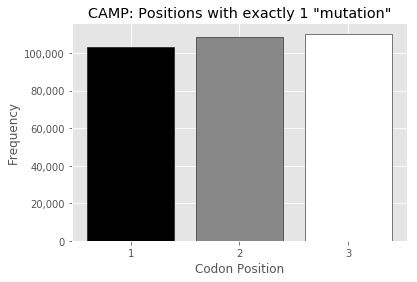

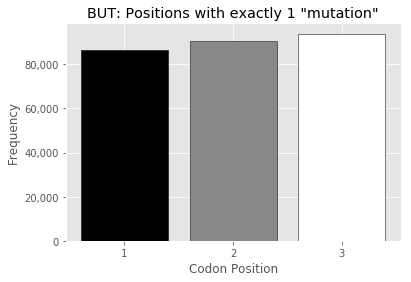

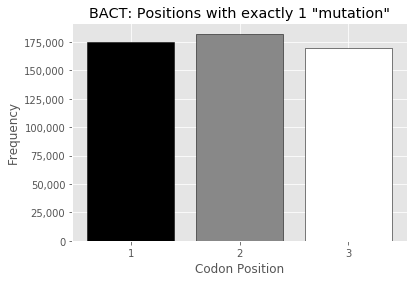

In [8]:
f = lambda cov, matches: 1 if matches == cov - 1 else 0
histogram_maker(f, 'Positions with exactly 1 "mutation"', normalize=False)

### Exactly 2 "mutations"

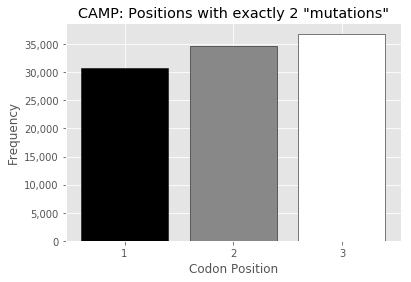

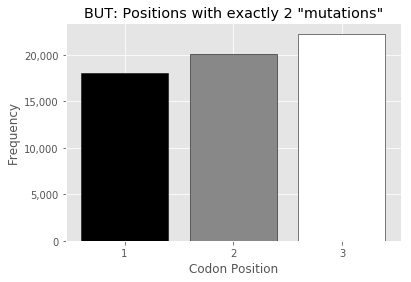

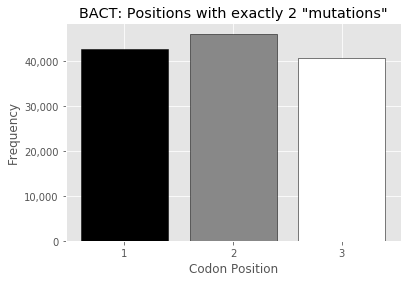

In [9]:
f = lambda cov, matches: 1 if matches == cov - 2 else 0
histogram_maker(f, 'Positions with exactly 2 "mutations"', normalize=False)

### Exactly 3 "mutations"

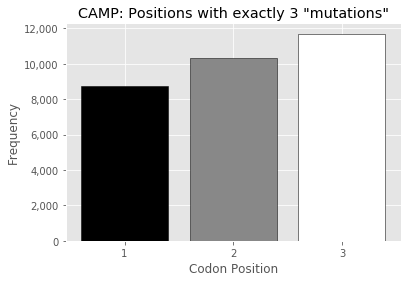

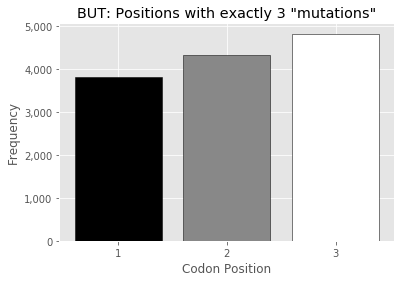

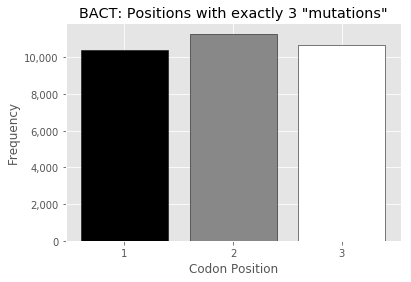

In [10]:
f = lambda cov, matches: 1 if matches == cov - 3 else 0
histogram_maker(f, 'Positions with exactly 3 "mutations"', normalize=False)

### Exactly 4 "mutations"

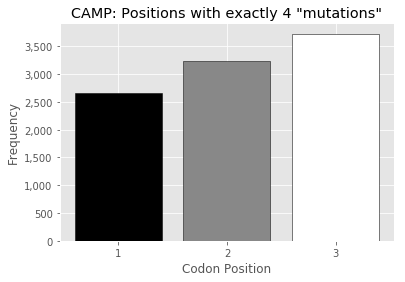

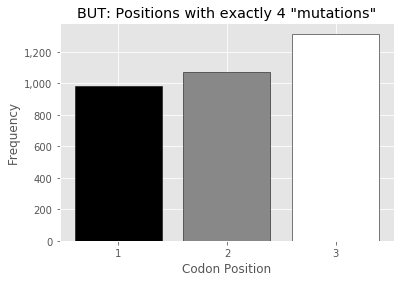

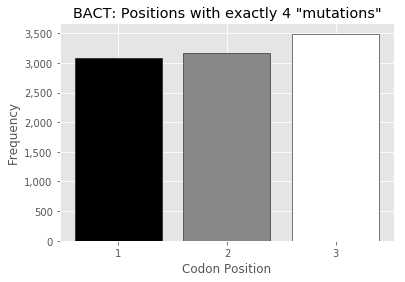

In [11]:
f = lambda cov, matches: 1 if matches == cov - 4 else 0
histogram_maker(f, 'Positions with exactly 4 "mutations"', normalize=False)

### At least one "mutation": normalize false, and normalize true

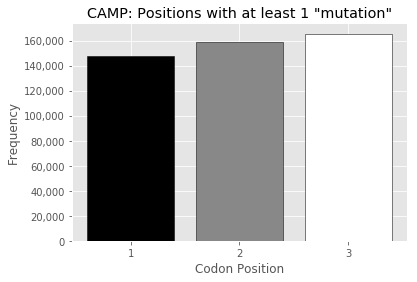

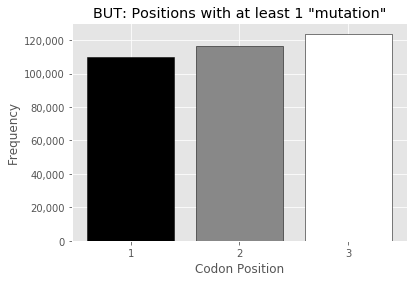

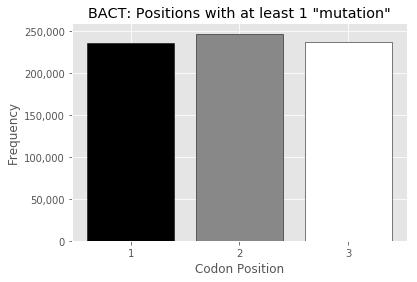

In [12]:
f = lambda cov, matches: 1 if matches < cov else 0
histogram_maker(f, 'Positions with at least 1 "mutation"', normalize=False)

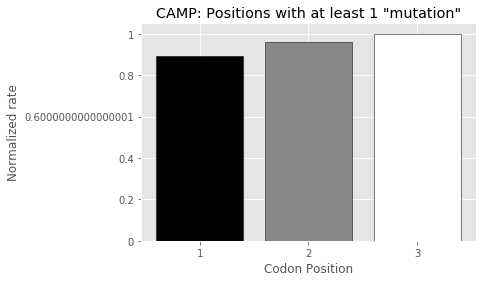

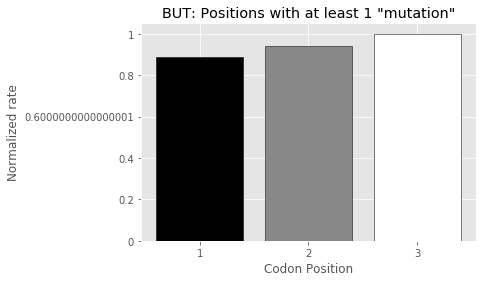

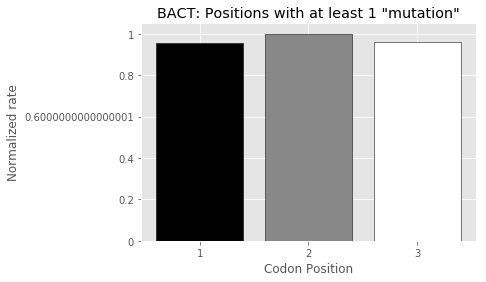

In [13]:
f = lambda cov, matches: 1 if matches < cov else 0
histogram_maker(f, 'Positions with at least 1 "mutation"', normalize=True)

### 10 or more "mutations"

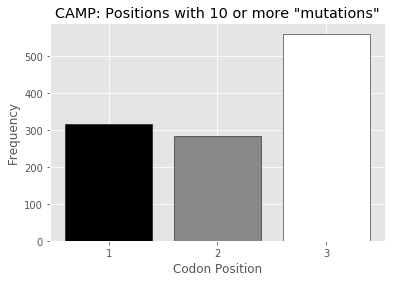

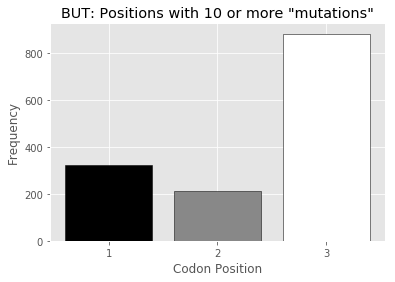

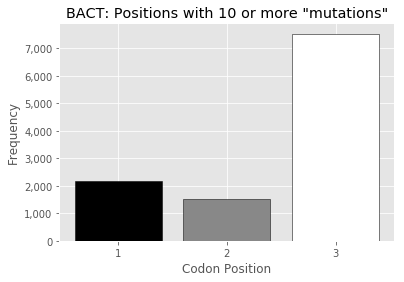

In [14]:
f = lambda cov, matches: 1 if matches <= cov - 10 else 0
histogram_maker(f, 'Positions with 10 or more "mutations"', normalize=False)

### 2%, 1%, 0.5%, 0.1% or more mutations

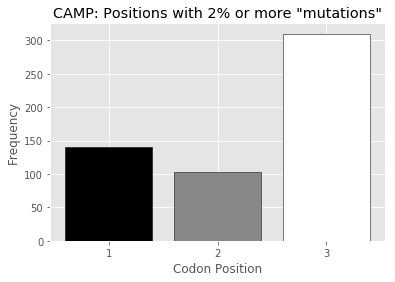

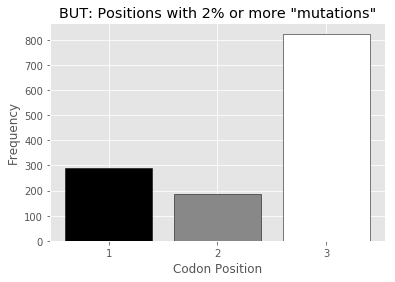

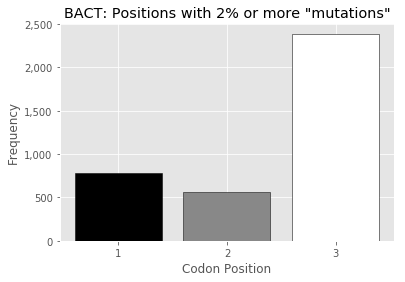

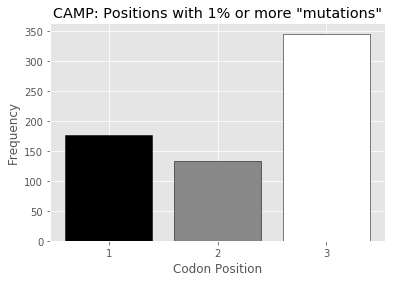

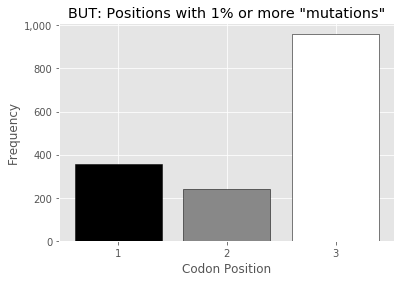

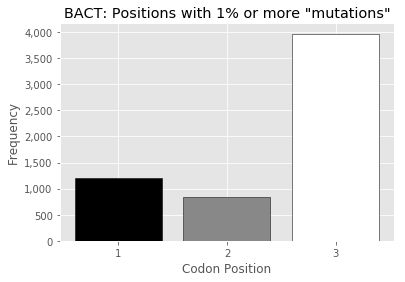

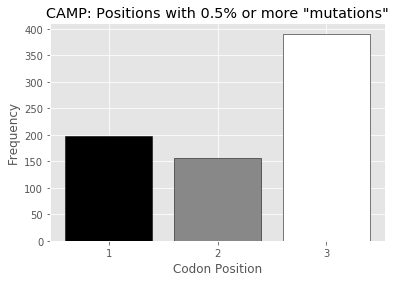

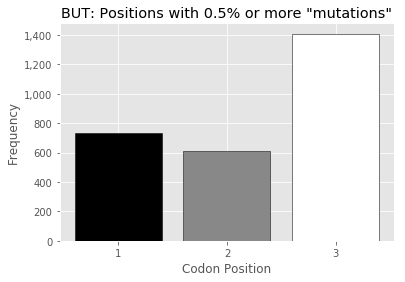

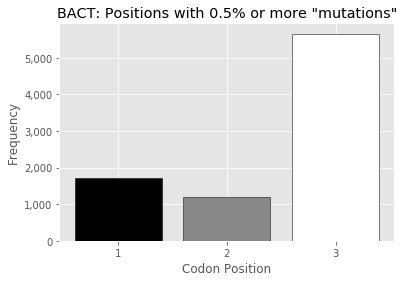

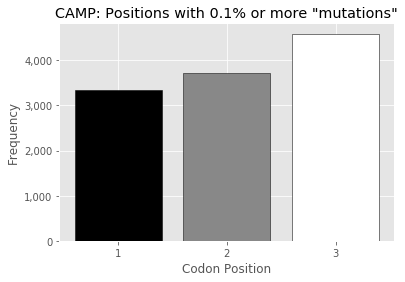

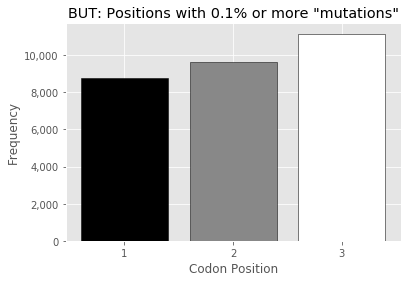

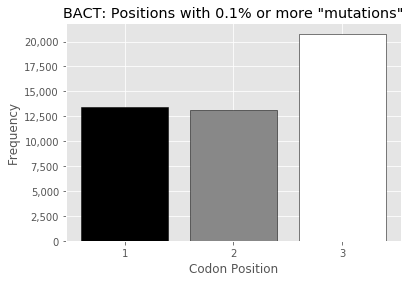

In [15]:
percentages = [2, 1, 0.5, 0.1]
for pct in percentages:
    threshold = pct / 100
    f = lambda cov, matches: 1 if 1 - (matches / cov) >= threshold else 0
    histogram_maker(f, 'Positions with {}% or more "mutations"'.format(pct), normalize=False)

### 50% or more "mutations"

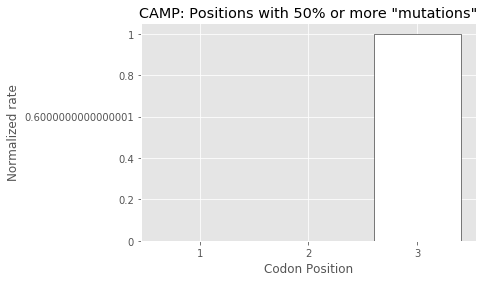

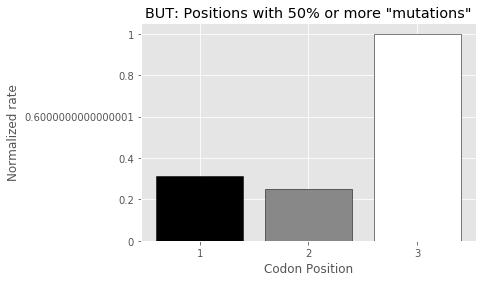

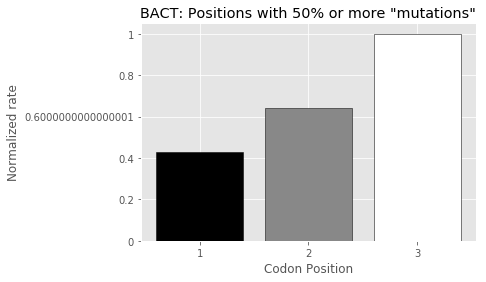

In [16]:
f = lambda cov, matches: 1 if 1 - (matches / cov) >= 0.5 else 0
histogram_maker(f, 'Positions with 50% or more "mutations"')

### Percentage-based methods (Fig. 2), no normalization

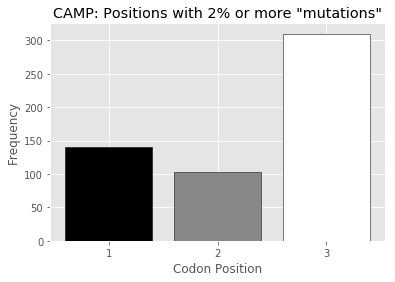

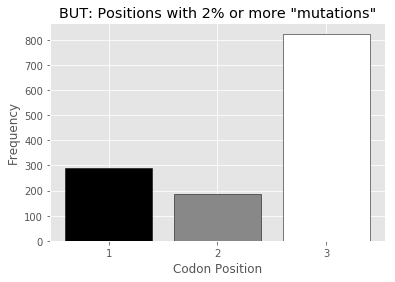

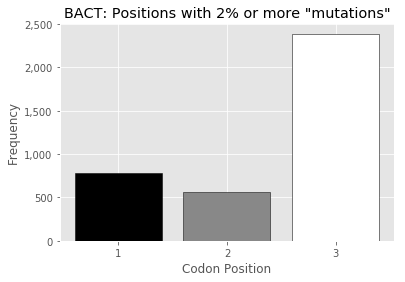

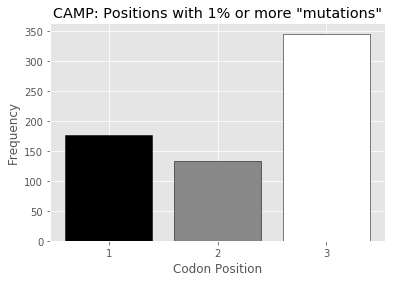

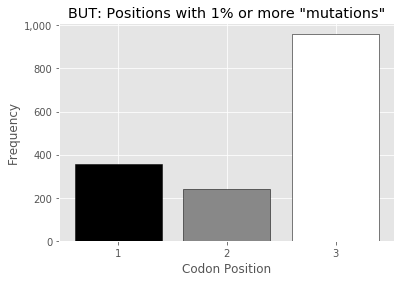

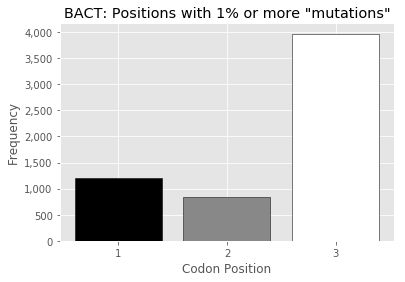

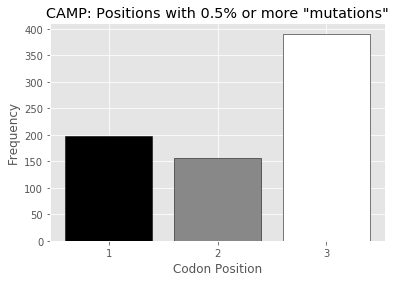

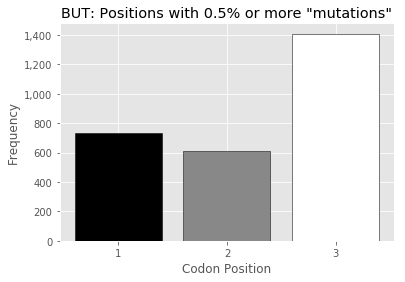

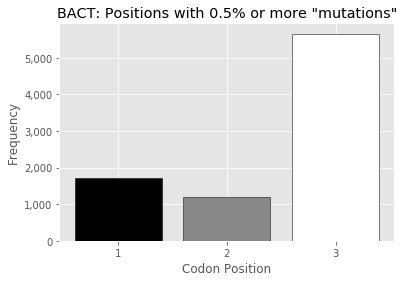

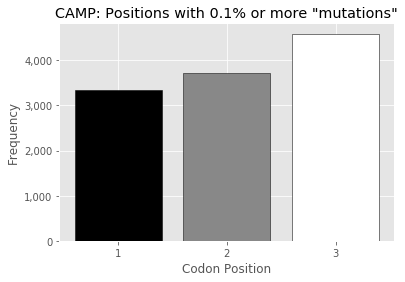

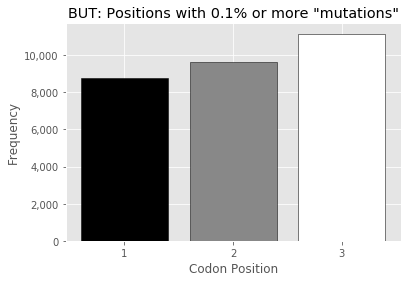

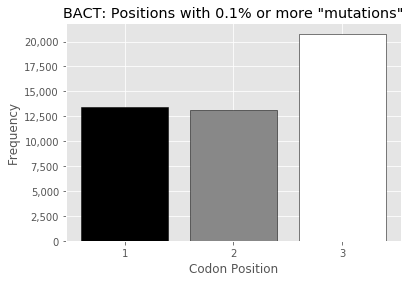

In [17]:
percentages = [2, 1, 0.5, 0.1]
for pct in percentages:
    threshold = pct / 100
    f = lambda cov, matches: 1 if 1 - (matches / cov) >= threshold else 0
    histogram_maker(f, 'Positions with {}% or more "mutations"'.format(pct), normalize=False)

### Average mutation rate

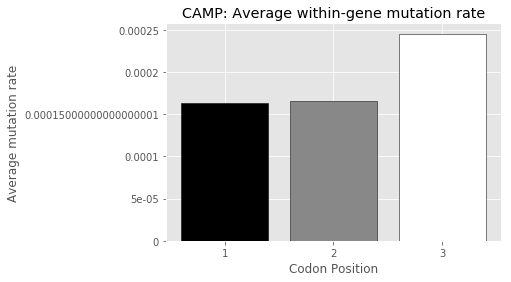

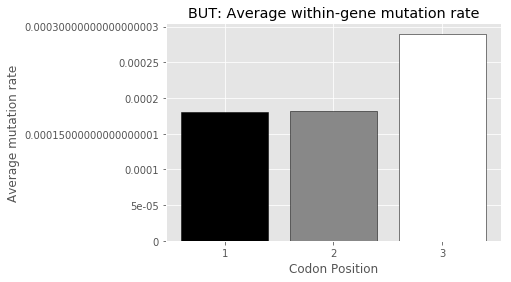

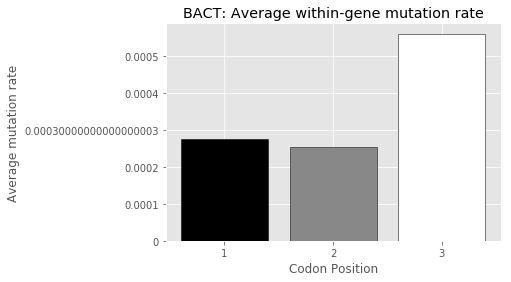

In [18]:
f = lambda cov, matches: 1 - (matches / cov)
seq2gene2rawvals = histogram_maker(f,
    "Average within-gene mutation rate", val_aggregator=mean, ylabel="Average mutation rate", normalize=False,
    output_dict=True
)

## Generate scatterplots of CP 1/2/3 mutated position proportions in genes

The goal is showing "outlier" genes with particularly high mutation rates.

In [89]:
def gene_scatterplot_maker(pseudo_variant_caller, output_dict=False, genes_to_highlight={}):
    """Shows scatterplots of mutated position proportions in the 1st, 2nd, and 3rd positions of predicted genes.

    Parameters
    ----------
    pseudo_variant_caller: function
        Works similarly to histogram_maker().
        Takes as input two parameters:
            1. cov: an integer describing number of reads aligned to a position
            2. matches: an integer describing the number of matching reads aligned to a position
            
        Should return a number: 1 if a position is "mutated", 0 if not mutated. Yeah, ideally this would
        return a bool, but numbers make this easier.
    """
    max_cp1_nm = 0
    max_cp2_nm = 0
    max_cp3_nm = 0
    seq2gene2normalizedmutct = {}
    for seq in SEQS:
        mgm = pd.read_csv(
            "/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/20201216_edges/{}_mgmgenes.txt".format(seq),
            sep="\s+", skiprows=[1], index_col=0, header=0,
            names=["Strand", "LeftEnd", "RightEnd", "Length", "Class"]
        )
        # Go through each gene in this sequence, and compute the (normalized) mutated-position frequency at
        # each of its three codon positions.
        seq2gene2normalizedmutct[seq] = {}
        for gene in mgm.itertuples():
            i = 1
            cp1_mutct = 0
            cp2_mutct = 0
            cp3_mutct = 0
            for pos in get_pos_interval_from_gene(gene):
                cov = seq2pos2cov[seq][str(pos)]
                matches = seq2pos2matches[seq][str(pos)]
                val = pseudo_variant_caller(cov, matches)
                if val not in [0, 1]:
                    raise ValueError("Output of pseudo_variant_caller should just be an 0 or 1.")
                if i == 1:
                    cp1_mutct += val
                    i = 2
                elif i == 2:
                    cp2_mutct += val
                    i = 3
                elif i == 3:
                    cp3_mutct += val
                    i = 1
                else:
                    raise ValueError("Codon position modulo calculation is broken :|")

            if i != 1:
                raise ValueError("Gene length not divisible by 3.")

            onethirdlen = gene.Length / 3
            nm1 = cp1_mutct / onethirdlen
            nm2 = cp2_mutct / onethirdlen
            nm3 = cp3_mutct / onethirdlen
            seq2gene2normalizedmutct[seq][gene.Index] = [nm1, nm2, nm3]
            # Try to update maxima
            max_cp1_nm = max(max_cp1_nm, nm1)
            max_cp2_nm = max(max_cp2_nm, nm2)
            max_cp3_nm = max(max_cp3_nm, nm3)

    # Only do plotting after we've seen all genes in all sequences. This ensures that we know the maximum
    # fraction of (mutated positions / one third gene length) across all CPs in all genes in all sequences.
    # (I mean, the theoretical maximum of this is just 1, in the case where all positions in a CP in a gene
    # are mutated... but that PROBABLY won't happen unless there are some really tiny and/or wacky genes)
    max_cp_nm = max(max_cp1_nm, max_cp2_nm, max_cp3_nm)
    
    
    # Compute scatterplots for CP 1 vs. CP 2 mutated-position frequencies for all genes
    # within this sequence
    def show_cp_vs_cp_plot(seq, x_cp, y_cp):
        """x_cp and y_cp should be 1-indexed CP numbers (one of [1, 2, 3])."""
        if x_cp not in [1,2,3] or y_cp not in [1,2,3]:
            raise ValueError("CPs must be one of [1, 2, 3].")
            
        gene_normalizedmutcts = seq2gene2normalizedmutct[seq].values()
        
        pyplot.title('{}: "Mutated position" frequencies in predicted genes'.format(seq2name[seq]))
        axis_label = "Normalized number of mutated positions in CP {}"
        pyplot.xlabel(axis_label.format(x_cp))
        pyplot.ylabel(axis_label.format(y_cp))
        
        # This is the default size of scatterplot points in matplotlib: see the "s" param docs
        # at https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html.
        dflt_size = (matplotlib.rcParams["lines.markersize"] ** 2)
        
        for gene in seq2gene2normalizedmutct[seq].keys():
            if gene in genes_to_highlight:
                color = genes_to_highlight[gene]
                # Double "size" of highlighted genes. There is a bit of ambiguity as to what exactly
                # "size" means (area?) -- see https://stackoverflow.com/a/47403507. Rather than spending 30
                # minutes doing a deep dive into this I'm just gonna multiply by four and call it a day
                size = 4 * dflt_size
            else:
                color = SCATTERPLOT_PT_COLOR
                size = dflt_size
            pyplot.scatter(
                seq2gene2normalizedmutct[seq][gene][x_cp - 1],
                seq2gene2normalizedmutct[seq][gene][y_cp - 1],
                c=color,
                s=size
            )
        
        pyplot.xlim(0, max_cp_nm)
        pyplot.ylim(0, max_cp_nm)
        
        # Plot diagonal line: https://stackoverflow.com/a/22105008
        # Get "ax": https://stackoverflow.com/a/15067854
        pyplot.plot(pyplot.gca().get_xlim(), pyplot.gca().get_ylim(), ls="--", c=".3")
        
        # Make figure square
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(6, 6)
        
        pyplot.show()
        
    for seq in SEQS:
        show_cp_vs_cp_plot(seq, 1, 2)        
        show_cp_vs_cp_plot(seq, 1, 3)
        
    if output_dict:
        return seq2gene2normalizedmutct

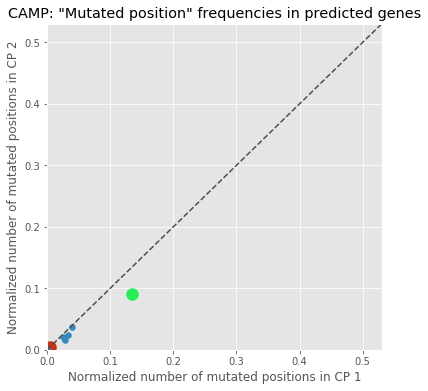

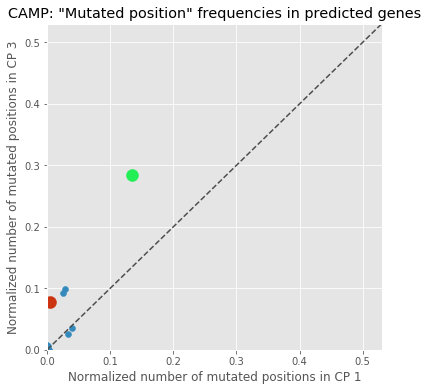

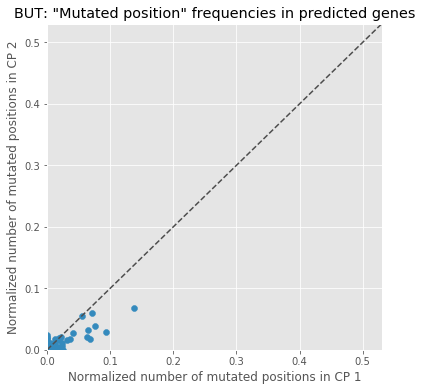

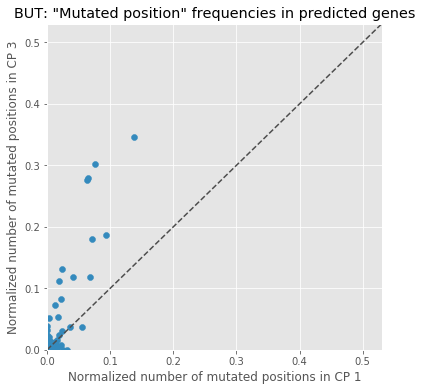

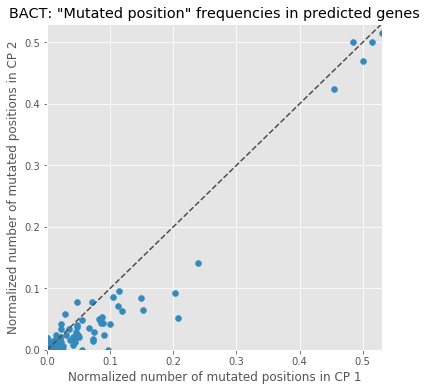

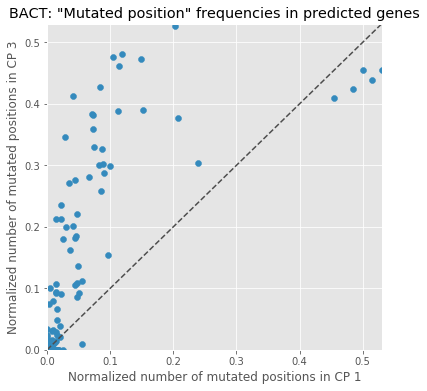

In [90]:
seq2gene2normalizedmutct = gene_scatterplot_maker(
    lambda cov, matches: 1 if 1 - (matches / cov) >= 0.01 else 0,
    True,
    {5317: "#cc3311", 4294: "#22ee55"}
)

In [62]:
# Focus on specific outlier genes in CAMP, manually... (ideally this would be paired with interactive plots
# using Altair or something but installing that is hard)
seq = "edge_6104"
for gene in seq2gene2normalizedmutct[seq]:
    if seq2gene2normalizedmutct[seq][gene][2] > 0.05:
        print(gene, seq2gene2normalizedmutct[seq][gene])

4179 [0.02857142857142857, 0.015238095238095238, 0.09904761904761905]
4294 [0.13513513513513514, 0.09073359073359073, 0.28378378378378377]
5071 [0.024667931688804556, 0.020872865275142316, 0.09297912713472485]
5317 [0.005221932114882507, 0.005221932114882507, 0.0783289817232376]


## Compute mutation profiles
Number of positions with one mutation, number of positions with two mutations, etc.

In [22]:
from collections import defaultdict
import os
from math import log

def get_mutation_profile(seq):
    num_mutations_to_freq = defaultdict(int)
    for pos in seq2pos2cov[seq]:
        # ignore uncovered places. Could also ignore places with less than some threshold coverage (e.g. 5)
        if seq2pos2cov[seq][pos] == 0:
            continue
        mutct = seq2pos2cov[seq][pos] - seq2pos2matches[seq][pos]
        num_mutations_to_freq[mutct] += 1
    return num_mutations_to_freq

def view_mutation_profiles(xlim_max=None, ylim_max=None, logscale=False):
    for seq in SEQS:
        num_mutations_to_freq = get_mutation_profile(seq)
        
        # .keys() and .values() should be in the same order: https://stackoverflow.com/a/835430
        pyplot.scatter(num_mutations_to_freq.keys(), num_mutations_to_freq.values(), c=SCATTERPLOT_PT_COLOR)
        
        ylabel = "How many positions have\nthis many mutations?"
        if logscale:
            # https://stackoverflow.com/a/14530857
            pyplot.gca().set_yscale("log")
            ylabel += " (log$_{10}$ scale)"
        pyplot.xlabel("Number of mutations")
        pyplot.ylabel(ylabel)
        
        title = "{}: Mutation Profile".format(seq2name[seq])
        
        if ylim_max is None:
            pyplot.ylim(0)
        else:
            pyplot.ylim(0, ylim_max)
            title += "\n(y-axis truncated to {})".format(ylim_max)
        if xlim_max is None:
            pyplot.xlim(0)
        else:
            pyplot.xlim(0, xlim_max)
            title += "\n(x-axis truncated to {})".format(xlim_max)
        pyplot.title(title)
        use_thousands_sep(pyplot.gca().xaxis)
        pyplot.show()

/home/marcus/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


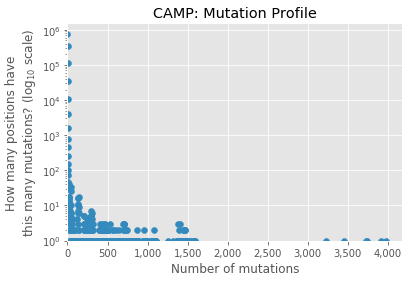

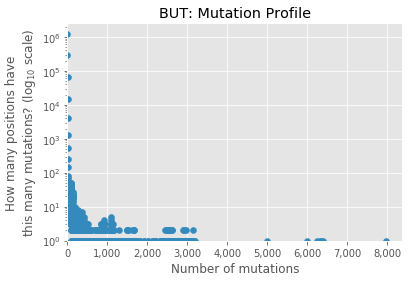

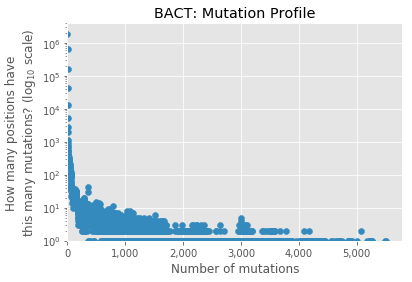

In [23]:
view_mutation_profiles(logscale=True)

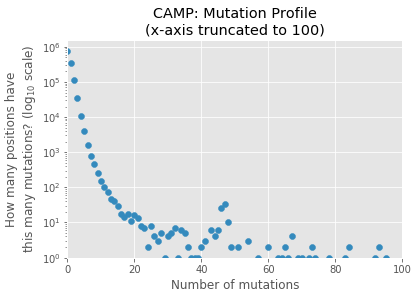

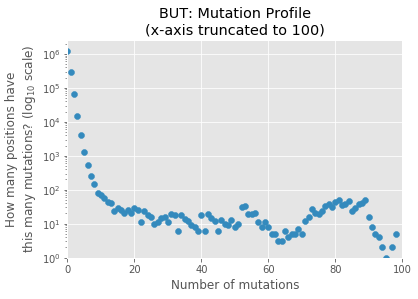

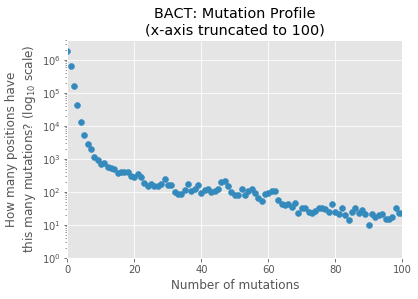

In [24]:
view_mutation_profiles(xlim_max=100, logscale=True)

## Plot along-gene mutation rates
We're gonna go with that one "outlier" gene in the scaffold, for now. But could of course generalize this to other genes.

In [26]:
def plot_gene_mutation_spectrum(seq, leftend, rightend):
    """leftend must be < rightend -- so if this is a reverse gene,
    the end position should still be leftend, I think.
    """
    one_cycle_through = False
    gene_positions = range(leftend, rightend + 1)
    cp = 1
    # We adopt the strategy here of calling pyplot.scatter() for each data point to plot, rather than
    # building up lists of x-axis, y-axis, and color values and plotting that. See e.g.
    # https://stackoverflow.com/questions/42180475#comment71523984_42180475 for documentation on this.
    for p in gene_positions:
        sp = str(p)
        cov = seq2pos2cov[seq][sp]
        num_discordant_reads = cov - seq2pos2matches[seq][sp]
        pct = num_discordant_reads / cov
        # If we assign a label to every datapoint, then the duplicate labels show up in the legend.
        # To avoid this, we just only assign labels to the first three points at a codon position:
        # https://stackoverflow.com/a/19386045.
        label = "" if one_cycle_through else "Codon Position {}".format(cp)
        pyplot.scatter(p, pct, c=cp2color[cp], label=label, edgecolor=BORDERCOLOR)
        if cp == 3:
            cp = 1
            one_cycle_through = True
        else:
            cp += 1

    pyplot.title("Mutation spectrum of a gene (left end: {:,}, right end: {:,}) in CAMP".format(leftend, rightend))
    pyplot.xlabel("Sequence position")
    # https://stackoverflow.com/a/27474400
    pyplot.ylabel("Percentage of mutations in aligned reads")
    pyplot.ylim(0)
    pyplot.legend()
    
    # Disable "offset" on the x-axis. This prevents matplotlib from replacing literal sequence positions with
    # smaller numbers and then adding a "+1.21e6" off to the side of the axis (which is... a lot more confusing
    # for this particular application than just listing the actual sequence positions). Doing this *after* the
    # percentage thing below doesn't seem to work, but doing it up here works. I dunno, matplotlib is hard.
    # See https://stackoverflow.com/a/28373421.
    pyplot.ticklabel_format(useOffset=False)
    
    # Make the y-axis show percentages: based on
    # https://old.reddit.com/r/learnpython/comments/7adhnk/matplotlib_setting_y_axis_labels_to_percent_yaxis/dp93fwq/
    pyplot.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
    
    # Use thousands separator on the x-axis
    use_thousands_sep(pyplot.gca().xaxis)
    
    # Make figure wide: https://stackoverflow.com/a/4306340
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(15, 5)

In [27]:
def plot_gene_coverage(seq, leftend, rightend):
    gene_positions = range(leftend, rightend + 1)
    one_cycle_through = False
    cp = 1
    for p in gene_positions:
        cov = seq2pos2cov[seq][str(p)]
        label = "" if one_cycle_through else "Codon Position {}".format(cp)
        pyplot.scatter(p, cov, c=cp2color[cp], label=label, edgecolor=BORDERCOLOR)
        if cp == 3:
            cp = 1
            one_cycle_through = True
        else:
            cp += 1

    pyplot.title("Coverage across a gene (left end: {:,}, right end: {:,}) in CAMP".format(leftend, rightend))
    pyplot.xlabel("Sequence position")
    pyplot.ylabel("Number of aligned reads to this position")
    pyplot.legend()
    pyplot.ticklabel_format(useOffset=False)
    use_thousands_sep(pyplot.gca().xaxis)
    use_thousands_sep(pyplot.gca().yaxis)
    # Make figure wide: https://stackoverflow.com/a/4306340
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(15, 5)

### Along-gene mutation rates for gene 5317 in CAMP (which exhibits "binarized" mutation rates)
The reason we go with this gene is it stood out really clearly in an earlier version of this analysis, where we were using the scaffold for CAMP rather than a single edge. It's still an outlier in the plot, just not the you know hugest one. That's to be expected, tho.

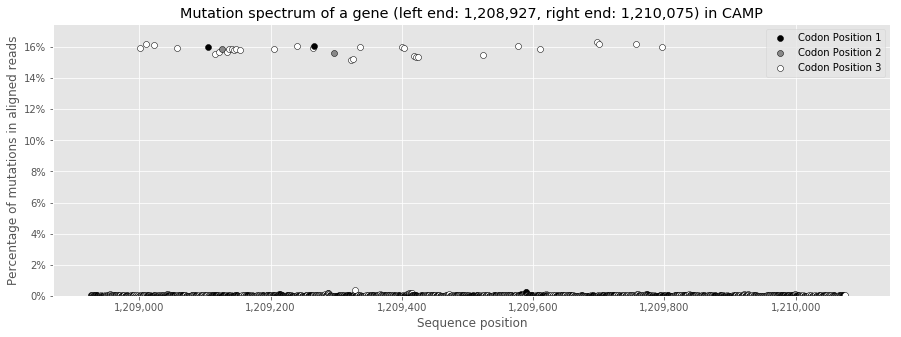

In [28]:
# The gene we're going to plot here is number 5317.
plot_gene_mutation_spectrum("edge_6104", 1208927, 1210075)

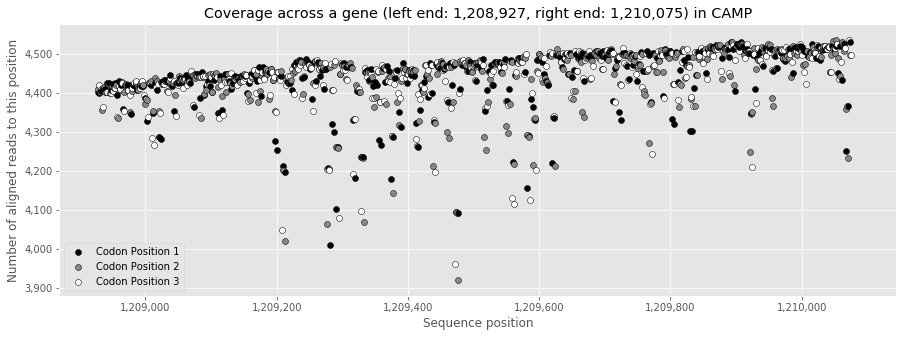

In [29]:
plot_gene_coverage("edge_6104", 1208927, 1210075)

### Along-gene mutation rates for gene 4294 in CAMP (less clearly defined pattern)

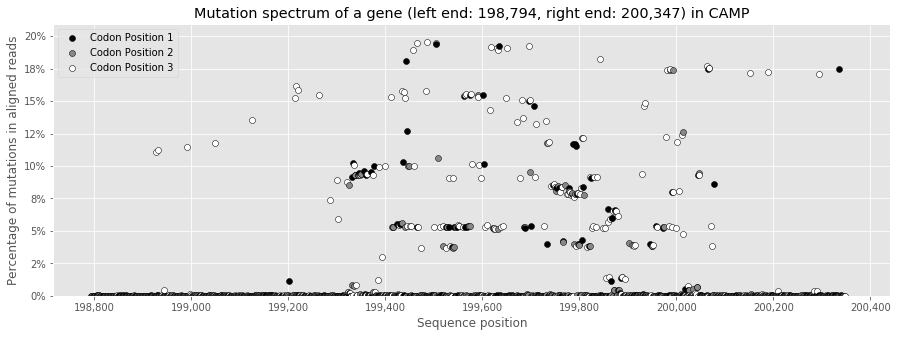

In [72]:
# The gene we're going to plot here is number 4294.
plot_gene_mutation_spectrum("edge_6104", 198794, 200347)

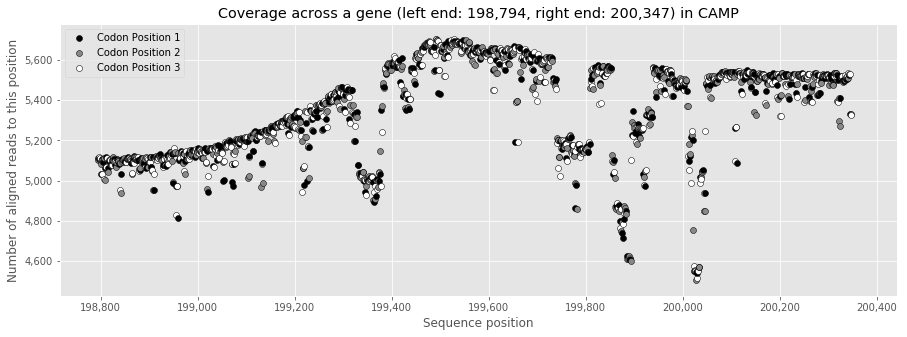

In [73]:
plot_gene_coverage("edge_6104", 198794, 200347)

### Plot coverages across genomes

In [30]:
def show_coverage_plot(seq):
    # seq2pos2cov stores positions as strings, but we need to plot them as ints
    int_positions = sorted([int(p) for p in seq2pos2cov[seq].keys()])
    str_positions = [str(p) for p in int_positions]
    coverages = [seq2pos2cov[seq][pos] for pos in str_positions]
    pyplot.scatter(int_positions, coverages, c=SCATTERPLOT_PT_COLOR)
    pyplot.title("{}: Coverage across genome".format(seq2name[seq]))
    pyplot.xlabel("Sequence position")
    pyplot.ylabel("Number of aligned reads to this position")
    
    # Limit the number of ticks on the x-axis, to avoid overlapping position labels.
    # https://stackoverflow.com/a/13418954
    pyplot.locator_params(axis="x", nbins=6)
    
    use_thousands_sep(pyplot.gca().xaxis)
    use_thousands_sep(pyplot.gca().yaxis)
    
    pyplot.show()

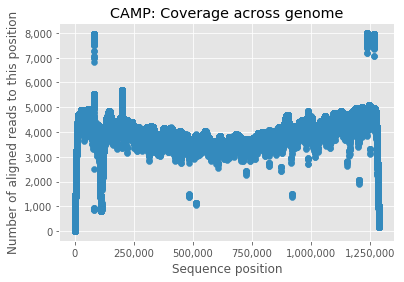

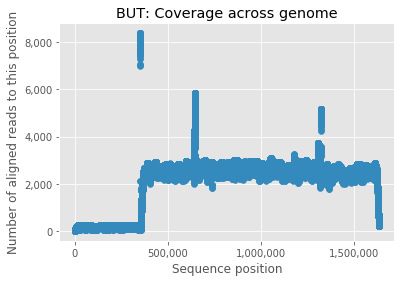

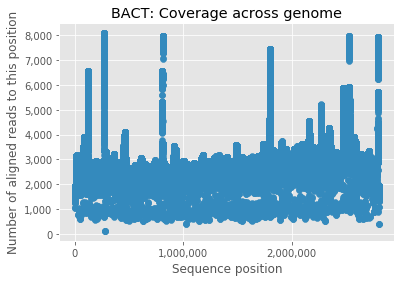

In [31]:
show_coverage_plot("edge_6104")
show_coverage_plot("edge_1371")
show_coverage_plot("edge_2358")

## Compute $N_1$, $N_2$, $N_3$ for each position in the genome

(We make the simplifying assumption in the following text that all reads contain only nucleotides, and don't contain degenerate bases like $Y$ or $N$.)

For a genomic position $P$ with a reference nucleotide $R \in \{A, C, G, T\}$, we consider three values: $N_1$, $N_2$, and $N_3$. __Ignoring reads aligned to $P$ that match $R$__, a read aligned to $P$ can have one of three other nucleotides at this position (for example, if $R$ is $A$, then these "non-matching" reads should only describe $C$, $G$, or $T$).

$N_1$, $N_2$, and $N_3$ define the number of non-matching reads aligned to $P$ for each of these three remaining nucleoides, such that $N_1 \geq N_2 \geq N_3$:

- $N_1$ is the number of non-matching reads that contain the most common "alternate" nucleotide at $P$.
- $N_2$ is the number of non-matching reads for the second-most common "alternate" nucleotide at $P$.
- $N_3$ is the number of non-matching reads for the third-most (least) common "alternate" nucleotide at $P$.

For example, if a given position in a reference sequence is $G$ and the covering reads for this position are:

- 100 $G$
- 1 $T$
- 50 $C$
- 5 $A$

Then we would say that $N_1$ = 50 (for $C$), $N_2$ = 5 (for $A$), and $N_3$ = 1 (for $T$).

We note that, for low-coverage and/or stable genomic positions, some or all of $N_1$, $N_2$, and $N_3$ may be zero.

We are interested in computing $f = \dfrac{N_1}{N_1 + N_2 + N_3}$ (which is only defined when $N_1 > 0$).

For a position with reasonably high coverage, high values of this fraction (at most $f = 1$) indicate that the metagenome likely has one primary "alternate" nucleotide at this position, while lower values (at lowest $f = \dfrac{1}{3}$) indicate that there are likely multiple "common" alternate nucleotides.

In [95]:
seq2pos2f = {}
for seq in SEQS:
    seq2pos2f[seq] = {}
    for pos in seq2pos2matches[seq]:
        num_matches = seq2pos2matches[seq][pos]
        non_matches = seq2pos2nonmatches[seq][pos]
        if len(non_matches) > 0:
            non_match_cts = non_matches.values()
            f = max(non_match_cts) / sum(non_match_cts)
            seq2pos2f[seq][pos] = f
        else:
            # There are no non-matches (i.e. all the aligned reads are matches), so N1, N2, and N3 are
            # all 0. This means that f is undefined (since it'd be 0/0).
            seq2pos2f[seq][pos] = None
            
# The following code computes "f" across the genomes.
# The plots are... not very informative.
#     pyplot.scatter([int(x) for x in seq2pos2f[seq].keys()], seq2pos2f[seq].values(), c=SCATTERPLOT_PT_COLOR)
#     pyplot.title("{}: f across genome, where defined and where coverage $\geq$ {}".format(
#         seq2name[seq], MIN_COV
#     ))
#     pyplot.xlabel("Sequence position")
#     pyplot.ylabel(r"$\dfrac{N_1}{N_1 + N_2 + N_3}$")
#     pyplot.locator_params(axis="x", nbins=5)
#     use_thousands_sep(pyplot.gca().xaxis)
#     pyplot.show()

## Save mutation profiles (and $\frac{N_1}{N_1 + N_2 + N_3}$ data) 

In [97]:
def save_mutation_profiles(output_dir="/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph"):
    """Partially copied from get_mutation_profile(), but extended."""
    
    num_mutations_to_freq = defaultdict(int)
    num_mutations_to_fvals = defaultdict(list)
    for seq in SEQS:
        for pos in seq2pos2cov[seq]:
            # ignore uncovered places. Could also ignore places with less than some threshold coverage (e.g. 5)
            if seq2pos2cov[seq][pos] == 0:
                continue
            mutct = seq2pos2cov[seq][pos] - seq2pos2matches[seq][pos]
#             if seq2pos2f[seq][pos] is None:
#                 if mutct > 0:
#                     print("uh oh: {} at pos={}".format(seq, pos))
            num_mutations_to_freq[mutct] += 1
            num_mutations_to_fvals[mutct].append(seq2pos2f[seq][pos])
            
        out_fn = os.path.join(output_dir, "{}_mutation_profile.tsv".format(seq2name[seq]))
        with open(out_fn, "w") as tsvf:
            tsvf.write("Number of mutations\tNumber of positions with exactly this many mutations\tAverage N1 / (N1 + N2 + N3)\n")
            for i in range(0, max(num_mutations_to_freq.keys()) + 1):
                if num_mutations_to_freq[i] > 0:
                    if None in num_mutations_to_fvals[i]:
                        print("found None in {} for i={}.".format(seq, i))
                        avg_f = "N/A"
                    else:
                        avg_f = sum(num_mutations_to_fvals[i]) / len(num_mutations_to_fvals[i])
                else:
                    avg_f = "N/A: no occurrences"
                tsvf.write("{}\t{}\t{}\n".format(
                    i, num_mutations_to_freq[i], avg_f
                ))
                
save_mutation_profiles()

uh oh: edge_6104 at pos=208
uh oh: edge_6104 at pos=392
uh oh: edge_6104 at pos=668
uh oh: edge_6104 at pos=680
uh oh: edge_6104 at pos=776
uh oh: edge_6104 at pos=815
uh oh: edge_6104 at pos=839
uh oh: edge_6104 at pos=872
uh oh: edge_6104 at pos=1010
uh oh: edge_6104 at pos=1133
uh oh: edge_6104 at pos=1176
uh oh: edge_6104 at pos=1177
uh oh: edge_6104 at pos=1244
uh oh: edge_6104 at pos=1397
uh oh: edge_6104 at pos=1430
uh oh: edge_6104 at pos=1467
uh oh: edge_6104 at pos=1498
uh oh: edge_6104 at pos=1513
uh oh: edge_6104 at pos=1561
uh oh: edge_6104 at pos=1582
uh oh: edge_6104 at pos=1638
uh oh: edge_6104 at pos=1769
uh oh: edge_6104 at pos=1795
uh oh: edge_6104 at pos=1813
uh oh: edge_6104 at pos=1814
uh oh: edge_6104 at pos=1816
uh oh: edge_6104 at pos=1827
uh oh: edge_6104 at pos=1885
uh oh: edge_6104 at pos=1908
uh oh: edge_6104 at pos=1951
uh oh: edge_6104 at pos=1990
uh oh: edge_6104 at pos=2031
uh oh: edge_6104 at pos=2051
uh oh: edge_6104 at pos=2106
uh oh: edge_6104 at po

uh oh: edge_6104 at pos=36920
uh oh: edge_6104 at pos=36921
uh oh: edge_6104 at pos=36973
uh oh: edge_6104 at pos=37041
uh oh: edge_6104 at pos=37080
uh oh: edge_6104 at pos=37091
uh oh: edge_6104 at pos=37103
uh oh: edge_6104 at pos=37105
uh oh: edge_6104 at pos=37149
uh oh: edge_6104 at pos=37152
uh oh: edge_6104 at pos=37157
uh oh: edge_6104 at pos=37159
uh oh: edge_6104 at pos=37179
uh oh: edge_6104 at pos=37212
uh oh: edge_6104 at pos=37219
uh oh: edge_6104 at pos=37223
uh oh: edge_6104 at pos=37270
uh oh: edge_6104 at pos=37305
uh oh: edge_6104 at pos=37307
uh oh: edge_6104 at pos=37339
uh oh: edge_6104 at pos=37352
uh oh: edge_6104 at pos=37379
uh oh: edge_6104 at pos=37390
uh oh: edge_6104 at pos=37400
uh oh: edge_6104 at pos=37414
uh oh: edge_6104 at pos=37420
uh oh: edge_6104 at pos=37424
uh oh: edge_6104 at pos=37426
uh oh: edge_6104 at pos=37438
uh oh: edge_6104 at pos=37449
uh oh: edge_6104 at pos=37456
uh oh: edge_6104 at pos=37467
uh oh: edge_6104 at pos=37468
uh oh: edg

uh oh: edge_6104 at pos=70368
uh oh: edge_6104 at pos=70425
uh oh: edge_6104 at pos=70443
uh oh: edge_6104 at pos=70457
uh oh: edge_6104 at pos=70474
uh oh: edge_6104 at pos=70481
uh oh: edge_6104 at pos=70506
uh oh: edge_6104 at pos=70516
uh oh: edge_6104 at pos=70521
uh oh: edge_6104 at pos=70531
uh oh: edge_6104 at pos=70554
uh oh: edge_6104 at pos=70569
uh oh: edge_6104 at pos=70582
uh oh: edge_6104 at pos=70601
uh oh: edge_6104 at pos=70610
uh oh: edge_6104 at pos=70647
uh oh: edge_6104 at pos=70649
uh oh: edge_6104 at pos=70654
uh oh: edge_6104 at pos=70655
uh oh: edge_6104 at pos=70668
uh oh: edge_6104 at pos=70678
uh oh: edge_6104 at pos=70691
uh oh: edge_6104 at pos=70699
uh oh: edge_6104 at pos=70701
uh oh: edge_6104 at pos=70707
uh oh: edge_6104 at pos=70711
uh oh: edge_6104 at pos=70718
uh oh: edge_6104 at pos=70723
uh oh: edge_6104 at pos=70726
uh oh: edge_6104 at pos=70752
uh oh: edge_6104 at pos=70761
uh oh: edge_6104 at pos=70777
uh oh: edge_6104 at pos=70805
uh oh: edg

uh oh: edge_6104 at pos=108524
uh oh: edge_6104 at pos=108530
uh oh: edge_6104 at pos=108543
uh oh: edge_6104 at pos=108570
uh oh: edge_6104 at pos=108581
uh oh: edge_6104 at pos=108606
uh oh: edge_6104 at pos=108710
uh oh: edge_6104 at pos=108727
uh oh: edge_6104 at pos=108728
uh oh: edge_6104 at pos=108768
uh oh: edge_6104 at pos=108779
uh oh: edge_6104 at pos=108780
uh oh: edge_6104 at pos=108781
uh oh: edge_6104 at pos=108822
uh oh: edge_6104 at pos=108843
uh oh: edge_6104 at pos=108849
uh oh: edge_6104 at pos=108865
uh oh: edge_6104 at pos=108866
uh oh: edge_6104 at pos=108868
uh oh: edge_6104 at pos=108870
uh oh: edge_6104 at pos=108881
uh oh: edge_6104 at pos=108936
uh oh: edge_6104 at pos=108943
uh oh: edge_6104 at pos=108954
uh oh: edge_6104 at pos=108964
uh oh: edge_6104 at pos=109011
uh oh: edge_6104 at pos=109056
uh oh: edge_6104 at pos=109085
uh oh: edge_6104 at pos=109126
uh oh: edge_6104 at pos=109156
uh oh: edge_6104 at pos=109215
uh oh: edge_6104 at pos=109235
uh oh: e

uh oh: edge_6104 at pos=147059
uh oh: edge_6104 at pos=147080
uh oh: edge_6104 at pos=147085
uh oh: edge_6104 at pos=147094
uh oh: edge_6104 at pos=147105
uh oh: edge_6104 at pos=147107
uh oh: edge_6104 at pos=147126
uh oh: edge_6104 at pos=147127
uh oh: edge_6104 at pos=147159
uh oh: edge_6104 at pos=147160
uh oh: edge_6104 at pos=147161
uh oh: edge_6104 at pos=147166
uh oh: edge_6104 at pos=147167
uh oh: edge_6104 at pos=147168
uh oh: edge_6104 at pos=147169
uh oh: edge_6104 at pos=147170
uh oh: edge_6104 at pos=147172
uh oh: edge_6104 at pos=147173
uh oh: edge_6104 at pos=147175
uh oh: edge_6104 at pos=147181
uh oh: edge_6104 at pos=147231
uh oh: edge_6104 at pos=147234
uh oh: edge_6104 at pos=147245
uh oh: edge_6104 at pos=147247
uh oh: edge_6104 at pos=147255
uh oh: edge_6104 at pos=147259
uh oh: edge_6104 at pos=147260
uh oh: edge_6104 at pos=147270
uh oh: edge_6104 at pos=147307
uh oh: edge_6104 at pos=147323
uh oh: edge_6104 at pos=147326
uh oh: edge_6104 at pos=147330
uh oh: e

uh oh: edge_6104 at pos=178120
uh oh: edge_6104 at pos=178124
uh oh: edge_6104 at pos=178128
uh oh: edge_6104 at pos=178146
uh oh: edge_6104 at pos=178148
uh oh: edge_6104 at pos=178149
uh oh: edge_6104 at pos=178153
uh oh: edge_6104 at pos=178159
uh oh: edge_6104 at pos=178179
uh oh: edge_6104 at pos=178180
uh oh: edge_6104 at pos=178183
uh oh: edge_6104 at pos=178188
uh oh: edge_6104 at pos=178209
uh oh: edge_6104 at pos=178221
uh oh: edge_6104 at pos=178226
uh oh: edge_6104 at pos=178242
uh oh: edge_6104 at pos=178253
uh oh: edge_6104 at pos=178256
uh oh: edge_6104 at pos=178273
uh oh: edge_6104 at pos=178333
uh oh: edge_6104 at pos=178335
uh oh: edge_6104 at pos=178336
uh oh: edge_6104 at pos=178345
uh oh: edge_6104 at pos=178359
uh oh: edge_6104 at pos=178366
uh oh: edge_6104 at pos=178367
uh oh: edge_6104 at pos=178428
uh oh: edge_6104 at pos=178431
uh oh: edge_6104 at pos=178432
uh oh: edge_6104 at pos=178441
uh oh: edge_6104 at pos=178450
uh oh: edge_6104 at pos=178453
uh oh: e

uh oh: edge_6104 at pos=210791
uh oh: edge_6104 at pos=210795
uh oh: edge_6104 at pos=210828
uh oh: edge_6104 at pos=210829
uh oh: edge_6104 at pos=210835
uh oh: edge_6104 at pos=210836
uh oh: edge_6104 at pos=210838
uh oh: edge_6104 at pos=210845
uh oh: edge_6104 at pos=210855
uh oh: edge_6104 at pos=210870
uh oh: edge_6104 at pos=210897
uh oh: edge_6104 at pos=210919
uh oh: edge_6104 at pos=210934
uh oh: edge_6104 at pos=210955
uh oh: edge_6104 at pos=210970
uh oh: edge_6104 at pos=210971
uh oh: edge_6104 at pos=210991
uh oh: edge_6104 at pos=211003
uh oh: edge_6104 at pos=211044
uh oh: edge_6104 at pos=211047
uh oh: edge_6104 at pos=211063
uh oh: edge_6104 at pos=211090
uh oh: edge_6104 at pos=211101
uh oh: edge_6104 at pos=211118
uh oh: edge_6104 at pos=211128
uh oh: edge_6104 at pos=211172
uh oh: edge_6104 at pos=211178
uh oh: edge_6104 at pos=211187
uh oh: edge_6104 at pos=211214
uh oh: edge_6104 at pos=211215
uh oh: edge_6104 at pos=211219
uh oh: edge_6104 at pos=211220
uh oh: e

uh oh: edge_6104 at pos=238749
uh oh: edge_6104 at pos=238786
uh oh: edge_6104 at pos=238833
uh oh: edge_6104 at pos=238842
uh oh: edge_6104 at pos=238887
uh oh: edge_6104 at pos=238888
uh oh: edge_6104 at pos=238891
uh oh: edge_6104 at pos=238959
uh oh: edge_6104 at pos=238960
uh oh: edge_6104 at pos=238961
uh oh: edge_6104 at pos=238964
uh oh: edge_6104 at pos=238985
uh oh: edge_6104 at pos=238986
uh oh: edge_6104 at pos=239013
uh oh: edge_6104 at pos=239014
uh oh: edge_6104 at pos=239020
uh oh: edge_6104 at pos=239021
uh oh: edge_6104 at pos=239027
uh oh: edge_6104 at pos=239034
uh oh: edge_6104 at pos=239047
uh oh: edge_6104 at pos=239069
uh oh: edge_6104 at pos=239081
uh oh: edge_6104 at pos=239146
uh oh: edge_6104 at pos=239152
uh oh: edge_6104 at pos=239167
uh oh: edge_6104 at pos=239168
uh oh: edge_6104 at pos=239169
uh oh: edge_6104 at pos=239184
uh oh: edge_6104 at pos=239188
uh oh: edge_6104 at pos=239217
uh oh: edge_6104 at pos=239220
uh oh: edge_6104 at pos=239225
uh oh: e

uh oh: edge_6104 at pos=272428
uh oh: edge_6104 at pos=272429
uh oh: edge_6104 at pos=272464
uh oh: edge_6104 at pos=272511
uh oh: edge_6104 at pos=272512
uh oh: edge_6104 at pos=272520
uh oh: edge_6104 at pos=272532
uh oh: edge_6104 at pos=272560
uh oh: edge_6104 at pos=272562
uh oh: edge_6104 at pos=272565
uh oh: edge_6104 at pos=272569
uh oh: edge_6104 at pos=272573
uh oh: edge_6104 at pos=272577
uh oh: edge_6104 at pos=272597
uh oh: edge_6104 at pos=272618
uh oh: edge_6104 at pos=272624
uh oh: edge_6104 at pos=272636
uh oh: edge_6104 at pos=272647
uh oh: edge_6104 at pos=272654
uh oh: edge_6104 at pos=272671
uh oh: edge_6104 at pos=272672
uh oh: edge_6104 at pos=272686
uh oh: edge_6104 at pos=272700
uh oh: edge_6104 at pos=272701
uh oh: edge_6104 at pos=272704
uh oh: edge_6104 at pos=272724
uh oh: edge_6104 at pos=272727
uh oh: edge_6104 at pos=272732
uh oh: edge_6104 at pos=272742
uh oh: edge_6104 at pos=272755
uh oh: edge_6104 at pos=272756
uh oh: edge_6104 at pos=272761
uh oh: e

uh oh: edge_6104 at pos=306762
uh oh: edge_6104 at pos=306764
uh oh: edge_6104 at pos=306765
uh oh: edge_6104 at pos=306770
uh oh: edge_6104 at pos=306771
uh oh: edge_6104 at pos=306780
uh oh: edge_6104 at pos=306782
uh oh: edge_6104 at pos=306809
uh oh: edge_6104 at pos=306824
uh oh: edge_6104 at pos=306837
uh oh: edge_6104 at pos=306850
uh oh: edge_6104 at pos=306888
uh oh: edge_6104 at pos=306911
uh oh: edge_6104 at pos=306914
uh oh: edge_6104 at pos=306930
uh oh: edge_6104 at pos=306952
uh oh: edge_6104 at pos=306953
uh oh: edge_6104 at pos=306954
uh oh: edge_6104 at pos=306955
uh oh: edge_6104 at pos=306956
uh oh: edge_6104 at pos=306959
uh oh: edge_6104 at pos=306980
uh oh: edge_6104 at pos=306989
uh oh: edge_6104 at pos=307004
uh oh: edge_6104 at pos=307016
uh oh: edge_6104 at pos=307023
uh oh: edge_6104 at pos=307047
uh oh: edge_6104 at pos=307049
uh oh: edge_6104 at pos=307054
uh oh: edge_6104 at pos=307058
uh oh: edge_6104 at pos=307067
uh oh: edge_6104 at pos=307074
uh oh: e

uh oh: edge_6104 at pos=342544
uh oh: edge_6104 at pos=342545
uh oh: edge_6104 at pos=342583
uh oh: edge_6104 at pos=342591
uh oh: edge_6104 at pos=342607
uh oh: edge_6104 at pos=342614
uh oh: edge_6104 at pos=342678
uh oh: edge_6104 at pos=342712
uh oh: edge_6104 at pos=342744
uh oh: edge_6104 at pos=342762
uh oh: edge_6104 at pos=342783
uh oh: edge_6104 at pos=342793
uh oh: edge_6104 at pos=342795
uh oh: edge_6104 at pos=342797
uh oh: edge_6104 at pos=342798
uh oh: edge_6104 at pos=342801
uh oh: edge_6104 at pos=342804
uh oh: edge_6104 at pos=342806
uh oh: edge_6104 at pos=342807
uh oh: edge_6104 at pos=342827
uh oh: edge_6104 at pos=342836
uh oh: edge_6104 at pos=342837
uh oh: edge_6104 at pos=342838
uh oh: edge_6104 at pos=342853
uh oh: edge_6104 at pos=342880
uh oh: edge_6104 at pos=342903
uh oh: edge_6104 at pos=342905
uh oh: edge_6104 at pos=342921
uh oh: edge_6104 at pos=342940
uh oh: edge_6104 at pos=342946
uh oh: edge_6104 at pos=342982
uh oh: edge_6104 at pos=342999
uh oh: e

uh oh: edge_6104 at pos=379981
uh oh: edge_6104 at pos=380018
uh oh: edge_6104 at pos=380032
uh oh: edge_6104 at pos=380033
uh oh: edge_6104 at pos=380037
uh oh: edge_6104 at pos=380043
uh oh: edge_6104 at pos=380048
uh oh: edge_6104 at pos=380053
uh oh: edge_6104 at pos=380081
uh oh: edge_6104 at pos=380087
uh oh: edge_6104 at pos=380095
uh oh: edge_6104 at pos=380098
uh oh: edge_6104 at pos=380108
uh oh: edge_6104 at pos=380147
uh oh: edge_6104 at pos=380166
uh oh: edge_6104 at pos=380187
uh oh: edge_6104 at pos=380217
uh oh: edge_6104 at pos=380244
uh oh: edge_6104 at pos=380247
uh oh: edge_6104 at pos=380255
uh oh: edge_6104 at pos=380277
uh oh: edge_6104 at pos=380296
uh oh: edge_6104 at pos=380307
uh oh: edge_6104 at pos=380339
uh oh: edge_6104 at pos=380354
uh oh: edge_6104 at pos=380365
uh oh: edge_6104 at pos=380370
uh oh: edge_6104 at pos=380371
uh oh: edge_6104 at pos=380372
uh oh: edge_6104 at pos=380373
uh oh: edge_6104 at pos=380395
uh oh: edge_6104 at pos=380396
uh oh: e

uh oh: edge_6104 at pos=409830
uh oh: edge_6104 at pos=409883
uh oh: edge_6104 at pos=409885
uh oh: edge_6104 at pos=409887
uh oh: edge_6104 at pos=409908
uh oh: edge_6104 at pos=409921
uh oh: edge_6104 at pos=409955
uh oh: edge_6104 at pos=409960
uh oh: edge_6104 at pos=409975
uh oh: edge_6104 at pos=410020
uh oh: edge_6104 at pos=410022
uh oh: edge_6104 at pos=410063
uh oh: edge_6104 at pos=410069
uh oh: edge_6104 at pos=410103
uh oh: edge_6104 at pos=410161
uh oh: edge_6104 at pos=410163
uh oh: edge_6104 at pos=410169
uh oh: edge_6104 at pos=410174
uh oh: edge_6104 at pos=410183
uh oh: edge_6104 at pos=410193
uh oh: edge_6104 at pos=410194
uh oh: edge_6104 at pos=410199
uh oh: edge_6104 at pos=410200
uh oh: edge_6104 at pos=410208
uh oh: edge_6104 at pos=410224
uh oh: edge_6104 at pos=410226
uh oh: edge_6104 at pos=410245
uh oh: edge_6104 at pos=410283
uh oh: edge_6104 at pos=410284
uh oh: edge_6104 at pos=410288
uh oh: edge_6104 at pos=410299
uh oh: edge_6104 at pos=410333
uh oh: e

uh oh: edge_6104 at pos=446302
uh oh: edge_6104 at pos=446309
uh oh: edge_6104 at pos=446311
uh oh: edge_6104 at pos=446313
uh oh: edge_6104 at pos=446318
uh oh: edge_6104 at pos=446342
uh oh: edge_6104 at pos=446355
uh oh: edge_6104 at pos=446361
uh oh: edge_6104 at pos=446362
uh oh: edge_6104 at pos=446370
uh oh: edge_6104 at pos=446403
uh oh: edge_6104 at pos=446429
uh oh: edge_6104 at pos=446430
uh oh: edge_6104 at pos=446431
uh oh: edge_6104 at pos=446442
uh oh: edge_6104 at pos=446445
uh oh: edge_6104 at pos=446446
uh oh: edge_6104 at pos=446450
uh oh: edge_6104 at pos=446460
uh oh: edge_6104 at pos=446465
uh oh: edge_6104 at pos=446470
uh oh: edge_6104 at pos=446490
uh oh: edge_6104 at pos=446514
uh oh: edge_6104 at pos=446519
uh oh: edge_6104 at pos=446556
uh oh: edge_6104 at pos=446562
uh oh: edge_6104 at pos=446656
uh oh: edge_6104 at pos=446662
uh oh: edge_6104 at pos=446663
uh oh: edge_6104 at pos=446671
uh oh: edge_6104 at pos=446679
uh oh: edge_6104 at pos=446680
uh oh: e

uh oh: edge_6104 at pos=478653
uh oh: edge_6104 at pos=478700
uh oh: edge_6104 at pos=478732
uh oh: edge_6104 at pos=478743
uh oh: edge_6104 at pos=478776
uh oh: edge_6104 at pos=478779
uh oh: edge_6104 at pos=478811
uh oh: edge_6104 at pos=478839
uh oh: edge_6104 at pos=478851
uh oh: edge_6104 at pos=478854
uh oh: edge_6104 at pos=478870
uh oh: edge_6104 at pos=478877
uh oh: edge_6104 at pos=478878
uh oh: edge_6104 at pos=478889
uh oh: edge_6104 at pos=478966
uh oh: edge_6104 at pos=478975
uh oh: edge_6104 at pos=478976
uh oh: edge_6104 at pos=478977
uh oh: edge_6104 at pos=478981
uh oh: edge_6104 at pos=479016
uh oh: edge_6104 at pos=479020
uh oh: edge_6104 at pos=479107
uh oh: edge_6104 at pos=479116
uh oh: edge_6104 at pos=479146
uh oh: edge_6104 at pos=479147
uh oh: edge_6104 at pos=479162
uh oh: edge_6104 at pos=479163
uh oh: edge_6104 at pos=479182
uh oh: edge_6104 at pos=479207
uh oh: edge_6104 at pos=479279
uh oh: edge_6104 at pos=479282
uh oh: edge_6104 at pos=479285
uh oh: e

uh oh: edge_6104 at pos=518227
uh oh: edge_6104 at pos=518238
uh oh: edge_6104 at pos=518246
uh oh: edge_6104 at pos=518286
uh oh: edge_6104 at pos=518295
uh oh: edge_6104 at pos=518331
uh oh: edge_6104 at pos=518332
uh oh: edge_6104 at pos=518367
uh oh: edge_6104 at pos=518385
uh oh: edge_6104 at pos=518427
uh oh: edge_6104 at pos=518439
uh oh: edge_6104 at pos=518451
uh oh: edge_6104 at pos=518459
uh oh: edge_6104 at pos=518471
uh oh: edge_6104 at pos=518486
uh oh: edge_6104 at pos=518489
uh oh: edge_6104 at pos=518498
uh oh: edge_6104 at pos=518552
uh oh: edge_6104 at pos=518588
uh oh: edge_6104 at pos=518611
uh oh: edge_6104 at pos=518628
uh oh: edge_6104 at pos=518630
uh oh: edge_6104 at pos=518691
uh oh: edge_6104 at pos=518711
uh oh: edge_6104 at pos=518723
uh oh: edge_6104 at pos=518724
uh oh: edge_6104 at pos=518730
uh oh: edge_6104 at pos=518731
uh oh: edge_6104 at pos=518770
uh oh: edge_6104 at pos=518780
uh oh: edge_6104 at pos=518784
uh oh: edge_6104 at pos=518797
uh oh: e

uh oh: edge_6104 at pos=556639
uh oh: edge_6104 at pos=556689
uh oh: edge_6104 at pos=556713
uh oh: edge_6104 at pos=556715
uh oh: edge_6104 at pos=556719
uh oh: edge_6104 at pos=556744
uh oh: edge_6104 at pos=556751
uh oh: edge_6104 at pos=556758
uh oh: edge_6104 at pos=556762
uh oh: edge_6104 at pos=556768
uh oh: edge_6104 at pos=556781
uh oh: edge_6104 at pos=556811
uh oh: edge_6104 at pos=556837
uh oh: edge_6104 at pos=556848
uh oh: edge_6104 at pos=556855
uh oh: edge_6104 at pos=556856
uh oh: edge_6104 at pos=556866
uh oh: edge_6104 at pos=556877
uh oh: edge_6104 at pos=556886
uh oh: edge_6104 at pos=556893
uh oh: edge_6104 at pos=556933
uh oh: edge_6104 at pos=556941
uh oh: edge_6104 at pos=556943
uh oh: edge_6104 at pos=556954
uh oh: edge_6104 at pos=556977
uh oh: edge_6104 at pos=556988
uh oh: edge_6104 at pos=557006
uh oh: edge_6104 at pos=557014
uh oh: edge_6104 at pos=557015
uh oh: edge_6104 at pos=557019
uh oh: edge_6104 at pos=557051
uh oh: edge_6104 at pos=557052
uh oh: e

uh oh: edge_6104 at pos=596232
uh oh: edge_6104 at pos=596234
uh oh: edge_6104 at pos=596239
uh oh: edge_6104 at pos=596244
uh oh: edge_6104 at pos=596254
uh oh: edge_6104 at pos=596283
uh oh: edge_6104 at pos=596300
uh oh: edge_6104 at pos=596326
uh oh: edge_6104 at pos=596331
uh oh: edge_6104 at pos=596345
uh oh: edge_6104 at pos=596346
uh oh: edge_6104 at pos=596352
uh oh: edge_6104 at pos=596359
uh oh: edge_6104 at pos=596372
uh oh: edge_6104 at pos=596373
uh oh: edge_6104 at pos=596379
uh oh: edge_6104 at pos=596436
uh oh: edge_6104 at pos=596518
uh oh: edge_6104 at pos=596535
uh oh: edge_6104 at pos=596545
uh oh: edge_6104 at pos=596566
uh oh: edge_6104 at pos=596569
uh oh: edge_6104 at pos=596601
uh oh: edge_6104 at pos=596615
uh oh: edge_6104 at pos=596623
uh oh: edge_6104 at pos=596624
uh oh: edge_6104 at pos=596643
uh oh: edge_6104 at pos=596660
uh oh: edge_6104 at pos=596670
uh oh: edge_6104 at pos=596678
uh oh: edge_6104 at pos=596691
uh oh: edge_6104 at pos=596772
uh oh: e

uh oh: edge_6104 at pos=634092
uh oh: edge_6104 at pos=634139
uh oh: edge_6104 at pos=634153
uh oh: edge_6104 at pos=634160
uh oh: edge_6104 at pos=634199
uh oh: edge_6104 at pos=634206
uh oh: edge_6104 at pos=634242
uh oh: edge_6104 at pos=634244
uh oh: edge_6104 at pos=634255
uh oh: edge_6104 at pos=634258
uh oh: edge_6104 at pos=634259
uh oh: edge_6104 at pos=634261
uh oh: edge_6104 at pos=634272
uh oh: edge_6104 at pos=634298
uh oh: edge_6104 at pos=634299
uh oh: edge_6104 at pos=634328
uh oh: edge_6104 at pos=634329
uh oh: edge_6104 at pos=634352
uh oh: edge_6104 at pos=634359
uh oh: edge_6104 at pos=634375
uh oh: edge_6104 at pos=634401
uh oh: edge_6104 at pos=634449
uh oh: edge_6104 at pos=634456
uh oh: edge_6104 at pos=634479
uh oh: edge_6104 at pos=634520
uh oh: edge_6104 at pos=634553
uh oh: edge_6104 at pos=634558
uh oh: edge_6104 at pos=634560
uh oh: edge_6104 at pos=634563
uh oh: edge_6104 at pos=634571
uh oh: edge_6104 at pos=634574
uh oh: edge_6104 at pos=634583
uh oh: e

uh oh: edge_6104 at pos=669246
uh oh: edge_6104 at pos=669256
uh oh: edge_6104 at pos=669278
uh oh: edge_6104 at pos=669287
uh oh: edge_6104 at pos=669298
uh oh: edge_6104 at pos=669316
uh oh: edge_6104 at pos=669320
uh oh: edge_6104 at pos=669339
uh oh: edge_6104 at pos=669340
uh oh: edge_6104 at pos=669341
uh oh: edge_6104 at pos=669347
uh oh: edge_6104 at pos=669389
uh oh: edge_6104 at pos=669416
uh oh: edge_6104 at pos=669430
uh oh: edge_6104 at pos=669438
uh oh: edge_6104 at pos=669441
uh oh: edge_6104 at pos=669477
uh oh: edge_6104 at pos=669478
uh oh: edge_6104 at pos=669487
uh oh: edge_6104 at pos=669489
uh oh: edge_6104 at pos=669502
uh oh: edge_6104 at pos=669513
uh oh: edge_6104 at pos=669518
uh oh: edge_6104 at pos=669542
uh oh: edge_6104 at pos=669549
uh oh: edge_6104 at pos=669557
uh oh: edge_6104 at pos=669560
uh oh: edge_6104 at pos=669562
uh oh: edge_6104 at pos=669579
uh oh: edge_6104 at pos=669593
uh oh: edge_6104 at pos=669594
uh oh: edge_6104 at pos=669617
uh oh: e

uh oh: edge_6104 at pos=705221
uh oh: edge_6104 at pos=705222
uh oh: edge_6104 at pos=705229
uh oh: edge_6104 at pos=705243
uh oh: edge_6104 at pos=705248
uh oh: edge_6104 at pos=705282
uh oh: edge_6104 at pos=705285
uh oh: edge_6104 at pos=705296
uh oh: edge_6104 at pos=705298
uh oh: edge_6104 at pos=705299
uh oh: edge_6104 at pos=705301
uh oh: edge_6104 at pos=705304
uh oh: edge_6104 at pos=705399
uh oh: edge_6104 at pos=705401
uh oh: edge_6104 at pos=705402
uh oh: edge_6104 at pos=705405
uh oh: edge_6104 at pos=705408
uh oh: edge_6104 at pos=705418
uh oh: edge_6104 at pos=705422
uh oh: edge_6104 at pos=705433
uh oh: edge_6104 at pos=705434
uh oh: edge_6104 at pos=705462
uh oh: edge_6104 at pos=705480
uh oh: edge_6104 at pos=705486
uh oh: edge_6104 at pos=705500
uh oh: edge_6104 at pos=705511
uh oh: edge_6104 at pos=705535
uh oh: edge_6104 at pos=705561
uh oh: edge_6104 at pos=705577
uh oh: edge_6104 at pos=705580
uh oh: edge_6104 at pos=705581
uh oh: edge_6104 at pos=705609
uh oh: e

uh oh: edge_6104 at pos=742829
uh oh: edge_6104 at pos=742830
uh oh: edge_6104 at pos=742846
uh oh: edge_6104 at pos=742850
uh oh: edge_6104 at pos=742851
uh oh: edge_6104 at pos=742861
uh oh: edge_6104 at pos=742863
uh oh: edge_6104 at pos=742866
uh oh: edge_6104 at pos=742895
uh oh: edge_6104 at pos=742902
uh oh: edge_6104 at pos=742910
uh oh: edge_6104 at pos=742912
uh oh: edge_6104 at pos=742929
uh oh: edge_6104 at pos=742936
uh oh: edge_6104 at pos=742964
uh oh: edge_6104 at pos=742984
uh oh: edge_6104 at pos=742985
uh oh: edge_6104 at pos=743001
uh oh: edge_6104 at pos=743002
uh oh: edge_6104 at pos=743003
uh oh: edge_6104 at pos=743004
uh oh: edge_6104 at pos=743005
uh oh: edge_6104 at pos=743017
uh oh: edge_6104 at pos=743024
uh oh: edge_6104 at pos=743036
uh oh: edge_6104 at pos=743040
uh oh: edge_6104 at pos=743053
uh oh: edge_6104 at pos=743054
uh oh: edge_6104 at pos=743093
uh oh: edge_6104 at pos=743100
uh oh: edge_6104 at pos=743116
uh oh: edge_6104 at pos=743117
uh oh: e

uh oh: edge_6104 at pos=778136
uh oh: edge_6104 at pos=778145
uh oh: edge_6104 at pos=778146
uh oh: edge_6104 at pos=778156
uh oh: edge_6104 at pos=778237
uh oh: edge_6104 at pos=778242
uh oh: edge_6104 at pos=778249
uh oh: edge_6104 at pos=778267
uh oh: edge_6104 at pos=778268
uh oh: edge_6104 at pos=778289
uh oh: edge_6104 at pos=778296
uh oh: edge_6104 at pos=778299
uh oh: edge_6104 at pos=778304
uh oh: edge_6104 at pos=778327
uh oh: edge_6104 at pos=778329
uh oh: edge_6104 at pos=778344
uh oh: edge_6104 at pos=778345
uh oh: edge_6104 at pos=778354
uh oh: edge_6104 at pos=778364
uh oh: edge_6104 at pos=778366
uh oh: edge_6104 at pos=778368
uh oh: edge_6104 at pos=778375
uh oh: edge_6104 at pos=778435
uh oh: edge_6104 at pos=778452
uh oh: edge_6104 at pos=778454
uh oh: edge_6104 at pos=778475
uh oh: edge_6104 at pos=778490
uh oh: edge_6104 at pos=778574
uh oh: edge_6104 at pos=778575
uh oh: edge_6104 at pos=778585
uh oh: edge_6104 at pos=778600
uh oh: edge_6104 at pos=778602
uh oh: e

uh oh: edge_6104 at pos=813279
uh oh: edge_6104 at pos=813280
uh oh: edge_6104 at pos=813281
uh oh: edge_6104 at pos=813282
uh oh: edge_6104 at pos=813284
uh oh: edge_6104 at pos=813315
uh oh: edge_6104 at pos=813349
uh oh: edge_6104 at pos=813351
uh oh: edge_6104 at pos=813381
uh oh: edge_6104 at pos=813397
uh oh: edge_6104 at pos=813398
uh oh: edge_6104 at pos=813400
uh oh: edge_6104 at pos=813408
uh oh: edge_6104 at pos=813413
uh oh: edge_6104 at pos=813422
uh oh: edge_6104 at pos=813430
uh oh: edge_6104 at pos=813431
uh oh: edge_6104 at pos=813436
uh oh: edge_6104 at pos=813495
uh oh: edge_6104 at pos=813496
uh oh: edge_6104 at pos=813510
uh oh: edge_6104 at pos=813548
uh oh: edge_6104 at pos=813555
uh oh: edge_6104 at pos=813591
uh oh: edge_6104 at pos=813600
uh oh: edge_6104 at pos=813604
uh oh: edge_6104 at pos=813647
uh oh: edge_6104 at pos=813656
uh oh: edge_6104 at pos=813673
uh oh: edge_6104 at pos=813705
uh oh: edge_6104 at pos=813706
uh oh: edge_6104 at pos=813722
uh oh: e

uh oh: edge_6104 at pos=846937
uh oh: edge_6104 at pos=846943
uh oh: edge_6104 at pos=846977
uh oh: edge_6104 at pos=846989
uh oh: edge_6104 at pos=846991
uh oh: edge_6104 at pos=847030
uh oh: edge_6104 at pos=847059
uh oh: edge_6104 at pos=847107
uh oh: edge_6104 at pos=847108
uh oh: edge_6104 at pos=847117
uh oh: edge_6104 at pos=847145
uh oh: edge_6104 at pos=847162
uh oh: edge_6104 at pos=847207
uh oh: edge_6104 at pos=847210
uh oh: edge_6104 at pos=847241
uh oh: edge_6104 at pos=847245
uh oh: edge_6104 at pos=847249
uh oh: edge_6104 at pos=847259
uh oh: edge_6104 at pos=847270
uh oh: edge_6104 at pos=847278
uh oh: edge_6104 at pos=847287
uh oh: edge_6104 at pos=847297
uh oh: edge_6104 at pos=847329
uh oh: edge_6104 at pos=847348
uh oh: edge_6104 at pos=847349
uh oh: edge_6104 at pos=847369
uh oh: edge_6104 at pos=847373
uh oh: edge_6104 at pos=847382
uh oh: edge_6104 at pos=847386
uh oh: edge_6104 at pos=847390
uh oh: edge_6104 at pos=847392
uh oh: edge_6104 at pos=847393
uh oh: e

uh oh: edge_6104 at pos=882677
uh oh: edge_6104 at pos=882695
uh oh: edge_6104 at pos=882726
uh oh: edge_6104 at pos=882727
uh oh: edge_6104 at pos=882752
uh oh: edge_6104 at pos=882753
uh oh: edge_6104 at pos=882755
uh oh: edge_6104 at pos=882762
uh oh: edge_6104 at pos=882763
uh oh: edge_6104 at pos=882764
uh oh: edge_6104 at pos=882770
uh oh: edge_6104 at pos=882774
uh oh: edge_6104 at pos=882775
uh oh: edge_6104 at pos=882782
uh oh: edge_6104 at pos=882807
uh oh: edge_6104 at pos=882822
uh oh: edge_6104 at pos=882831
uh oh: edge_6104 at pos=882867
uh oh: edge_6104 at pos=882872
uh oh: edge_6104 at pos=882873
uh oh: edge_6104 at pos=882885
uh oh: edge_6104 at pos=882897
uh oh: edge_6104 at pos=882909
uh oh: edge_6104 at pos=882924
uh oh: edge_6104 at pos=882926
uh oh: edge_6104 at pos=882936
uh oh: edge_6104 at pos=882944
uh oh: edge_6104 at pos=882949
uh oh: edge_6104 at pos=882954
uh oh: edge_6104 at pos=882956
uh oh: edge_6104 at pos=882980
uh oh: edge_6104 at pos=882999
uh oh: e

uh oh: edge_6104 at pos=913953
uh oh: edge_6104 at pos=913954
uh oh: edge_6104 at pos=913957
uh oh: edge_6104 at pos=913967
uh oh: edge_6104 at pos=914022
uh oh: edge_6104 at pos=914023
uh oh: edge_6104 at pos=914046
uh oh: edge_6104 at pos=914052
uh oh: edge_6104 at pos=914061
uh oh: edge_6104 at pos=914073
uh oh: edge_6104 at pos=914128
uh oh: edge_6104 at pos=914133
uh oh: edge_6104 at pos=914134
uh oh: edge_6104 at pos=914157
uh oh: edge_6104 at pos=914177
uh oh: edge_6104 at pos=914200
uh oh: edge_6104 at pos=914210
uh oh: edge_6104 at pos=914214
uh oh: edge_6104 at pos=914220
uh oh: edge_6104 at pos=914226
uh oh: edge_6104 at pos=914228
uh oh: edge_6104 at pos=914232
uh oh: edge_6104 at pos=914234
uh oh: edge_6104 at pos=914245
uh oh: edge_6104 at pos=914259
uh oh: edge_6104 at pos=914274
uh oh: edge_6104 at pos=914276
uh oh: edge_6104 at pos=914278
uh oh: edge_6104 at pos=914288
uh oh: edge_6104 at pos=914290
uh oh: edge_6104 at pos=914291
uh oh: edge_6104 at pos=914292
uh oh: e

uh oh: edge_6104 at pos=951062
uh oh: edge_6104 at pos=951063
uh oh: edge_6104 at pos=951158
uh oh: edge_6104 at pos=951166
uh oh: edge_6104 at pos=951180
uh oh: edge_6104 at pos=951189
uh oh: edge_6104 at pos=951190
uh oh: edge_6104 at pos=951191
uh oh: edge_6104 at pos=951203
uh oh: edge_6104 at pos=951216
uh oh: edge_6104 at pos=951231
uh oh: edge_6104 at pos=951295
uh oh: edge_6104 at pos=951320
uh oh: edge_6104 at pos=951339
uh oh: edge_6104 at pos=951359
uh oh: edge_6104 at pos=951364
uh oh: edge_6104 at pos=951383
uh oh: edge_6104 at pos=951387
uh oh: edge_6104 at pos=951390
uh oh: edge_6104 at pos=951410
uh oh: edge_6104 at pos=951413
uh oh: edge_6104 at pos=951450
uh oh: edge_6104 at pos=951472
uh oh: edge_6104 at pos=951484
uh oh: edge_6104 at pos=951493
uh oh: edge_6104 at pos=951514
uh oh: edge_6104 at pos=951519
uh oh: edge_6104 at pos=951529
uh oh: edge_6104 at pos=951625
uh oh: edge_6104 at pos=951633
uh oh: edge_6104 at pos=951642
uh oh: edge_6104 at pos=951652
uh oh: e

uh oh: edge_6104 at pos=985060
uh oh: edge_6104 at pos=985061
uh oh: edge_6104 at pos=985062
uh oh: edge_6104 at pos=985066
uh oh: edge_6104 at pos=985067
uh oh: edge_6104 at pos=985069
uh oh: edge_6104 at pos=985101
uh oh: edge_6104 at pos=985104
uh oh: edge_6104 at pos=985150
uh oh: edge_6104 at pos=985155
uh oh: edge_6104 at pos=985184
uh oh: edge_6104 at pos=985207
uh oh: edge_6104 at pos=985213
uh oh: edge_6104 at pos=985222
uh oh: edge_6104 at pos=985225
uh oh: edge_6104 at pos=985236
uh oh: edge_6104 at pos=985237
uh oh: edge_6104 at pos=985239
uh oh: edge_6104 at pos=985249
uh oh: edge_6104 at pos=985255
uh oh: edge_6104 at pos=985269
uh oh: edge_6104 at pos=985285
uh oh: edge_6104 at pos=985366
uh oh: edge_6104 at pos=985377
uh oh: edge_6104 at pos=985387
uh oh: edge_6104 at pos=985390
uh oh: edge_6104 at pos=985392
uh oh: edge_6104 at pos=985394
uh oh: edge_6104 at pos=985401
uh oh: edge_6104 at pos=985408
uh oh: edge_6104 at pos=985417
uh oh: edge_6104 at pos=985418
uh oh: e

uh oh: edge_6104 at pos=1017301
uh oh: edge_6104 at pos=1017302
uh oh: edge_6104 at pos=1017306
uh oh: edge_6104 at pos=1017308
uh oh: edge_6104 at pos=1017312
uh oh: edge_6104 at pos=1017368
uh oh: edge_6104 at pos=1017379
uh oh: edge_6104 at pos=1017406
uh oh: edge_6104 at pos=1017492
uh oh: edge_6104 at pos=1017530
uh oh: edge_6104 at pos=1017548
uh oh: edge_6104 at pos=1017592
uh oh: edge_6104 at pos=1017596
uh oh: edge_6104 at pos=1017621
uh oh: edge_6104 at pos=1017654
uh oh: edge_6104 at pos=1017664
uh oh: edge_6104 at pos=1017665
uh oh: edge_6104 at pos=1017666
uh oh: edge_6104 at pos=1017671
uh oh: edge_6104 at pos=1017678
uh oh: edge_6104 at pos=1017704
uh oh: edge_6104 at pos=1017705
uh oh: edge_6104 at pos=1017711
uh oh: edge_6104 at pos=1017760
uh oh: edge_6104 at pos=1017778
uh oh: edge_6104 at pos=1017788
uh oh: edge_6104 at pos=1017823
uh oh: edge_6104 at pos=1017832
uh oh: edge_6104 at pos=1017900
uh oh: edge_6104 at pos=1017937
uh oh: edge_6104 at pos=1017947
uh oh: e

uh oh: edge_6104 at pos=1051083
uh oh: edge_6104 at pos=1051093
uh oh: edge_6104 at pos=1051094
uh oh: edge_6104 at pos=1051095
uh oh: edge_6104 at pos=1051107
uh oh: edge_6104 at pos=1051137
uh oh: edge_6104 at pos=1051148
uh oh: edge_6104 at pos=1051150
uh oh: edge_6104 at pos=1051153
uh oh: edge_6104 at pos=1051154
uh oh: edge_6104 at pos=1051168
uh oh: edge_6104 at pos=1051183
uh oh: edge_6104 at pos=1051197
uh oh: edge_6104 at pos=1051199
uh oh: edge_6104 at pos=1051214
uh oh: edge_6104 at pos=1051225
uh oh: edge_6104 at pos=1051252
uh oh: edge_6104 at pos=1051262
uh oh: edge_6104 at pos=1051278
uh oh: edge_6104 at pos=1051350
uh oh: edge_6104 at pos=1051359
uh oh: edge_6104 at pos=1051377
uh oh: edge_6104 at pos=1051378
uh oh: edge_6104 at pos=1051379
uh oh: edge_6104 at pos=1051399
uh oh: edge_6104 at pos=1051407
uh oh: edge_6104 at pos=1051425
uh oh: edge_6104 at pos=1051468
uh oh: edge_6104 at pos=1051483
uh oh: edge_6104 at pos=1051491
uh oh: edge_6104 at pos=1051561
uh oh: e

uh oh: edge_6104 at pos=1081486
uh oh: edge_6104 at pos=1081489
uh oh: edge_6104 at pos=1081492
uh oh: edge_6104 at pos=1081499
uh oh: edge_6104 at pos=1081506
uh oh: edge_6104 at pos=1081510
uh oh: edge_6104 at pos=1081513
uh oh: edge_6104 at pos=1081515
uh oh: edge_6104 at pos=1081525
uh oh: edge_6104 at pos=1081527
uh oh: edge_6104 at pos=1081528
uh oh: edge_6104 at pos=1081540
uh oh: edge_6104 at pos=1081548
uh oh: edge_6104 at pos=1081551
uh oh: edge_6104 at pos=1081553
uh oh: edge_6104 at pos=1081629
uh oh: edge_6104 at pos=1081630
uh oh: edge_6104 at pos=1081636
uh oh: edge_6104 at pos=1081661
uh oh: edge_6104 at pos=1081690
uh oh: edge_6104 at pos=1081693
uh oh: edge_6104 at pos=1081803
uh oh: edge_6104 at pos=1081806
uh oh: edge_6104 at pos=1081813
uh oh: edge_6104 at pos=1081823
uh oh: edge_6104 at pos=1081826
uh oh: edge_6104 at pos=1081861
uh oh: edge_6104 at pos=1081868
uh oh: edge_6104 at pos=1081872
uh oh: edge_6104 at pos=1081880
uh oh: edge_6104 at pos=1081900
uh oh: e

uh oh: edge_6104 at pos=1116619
uh oh: edge_6104 at pos=1116624
uh oh: edge_6104 at pos=1116660
uh oh: edge_6104 at pos=1116673
uh oh: edge_6104 at pos=1116676
uh oh: edge_6104 at pos=1116681
uh oh: edge_6104 at pos=1116682
uh oh: edge_6104 at pos=1116694
uh oh: edge_6104 at pos=1116701
uh oh: edge_6104 at pos=1116720
uh oh: edge_6104 at pos=1116723
uh oh: edge_6104 at pos=1116725
uh oh: edge_6104 at pos=1116741
uh oh: edge_6104 at pos=1116745
uh oh: edge_6104 at pos=1116771
uh oh: edge_6104 at pos=1116775
uh oh: edge_6104 at pos=1116776
uh oh: edge_6104 at pos=1116777
uh oh: edge_6104 at pos=1116796
uh oh: edge_6104 at pos=1116838
uh oh: edge_6104 at pos=1116876
uh oh: edge_6104 at pos=1116879
uh oh: edge_6104 at pos=1116880
uh oh: edge_6104 at pos=1116893
uh oh: edge_6104 at pos=1116900
uh oh: edge_6104 at pos=1116906
uh oh: edge_6104 at pos=1116907
uh oh: edge_6104 at pos=1116910
uh oh: edge_6104 at pos=1116911
uh oh: edge_6104 at pos=1116926
uh oh: edge_6104 at pos=1116933
uh oh: e

KeyboardInterrupt: 

In [102]:
seq2pos2cov["edge_6104"]["208"]
seq2pos2matches["edge_6104"]["208"]
seq2pos2nonmatches["edge_6104"]["208"]

129